# Projet MDS #

This notebook contains a part of the work made by Grégoire Gissot for the project MDS. In this notebook, the objective is to do some multiway analysis to see what can be said about the data and what can done in term of prediction (particularly of the tumor).

As the other part, it is important to keep in mind for the data : 
- The global data has a multiway vision since it is an array individual x features x time (see previous notebook)
- The slice data has a multiway vision but 4D-tensor with an array individual x features x slices x time

The extraction of the data has already been discussed in a previous notebook.

This contains mainly three parts :
- Preprocessing and utils objects 
- Visualisation using PARAFAC
- Prediction of the tumors using Multiway Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorly as ts

### Preprocessing and utils ###

It is mainly loading the data and recuperating the names of the feature for a better experiment (for more details about the data see extraction_and_save.ipynb).

### Load the data ###

In [2]:
PATH_TO_DATA_SLICE = "./Données-20240401/radiomiques_multislice.xlsx"
PATH_TO_DATA_GLOBAL = "./Données-20240401/radiomiques_global.xlsx"
PATH_TO_DATA_PATIENT = "./Données-20240401/Descriptif_patients.xlsx"

Recuperate the names of the features.

In [3]:
# Load the data
df = pd.read_excel(PATH_TO_DATA_GLOBAL, sheet_name="liver_tumors_all_LLB")
df = df.loc[:, ~df.columns.str.startswith("diagnostic")]
df = df.loc[:, ~df.columns.str.startswith("Unnamed")]
df = df.loc[:, ~df.columns.str.startswith("Column")]
df.drop(columns=["temps_inj", "patient_num", "classe_name"], inplace=True)

global_columns = df.columns

dic_global = {i: global_columns[i] for i in range(len(global_columns))}

In [4]:
# Load the data
df_slice = pd.read_excel(PATH_TO_DATA_SLICE, sheet_name="liver_tumors_slices_LLB")
df_slice = df_slice.loc[:, ~df_slice.columns.str.startswith("diagnostic")]
df_slice = df_slice.loc[:, ~df_slice.columns.str.startswith("Unnamed")]
df_slice = df_slice.loc[:, ~df_slice.columns.str.startswith("Column")]
df_slice.drop(
    columns=["temps_inj", "patient_num", "classe_name", "slice_num"], inplace=True
)

slice_columns = df_slice.columns

dic_slice = {i: slice_columns[i] for i in range(len(slice_columns))}

In [5]:
print(len(dic_global), len(dic_slice))

107 93


Load the data (tensor format).

In [6]:
PATH_TO_TENSOR_GLOBAL = "./Données-20240401/global_tensored_data.npy"
PATH_TO_TENSOR_SLICE = "./Données-20240401/tensored_data_3slices.npy"

In [7]:
tensor_global = np.load(PATH_TO_TENSOR_GLOBAL, allow_pickle=True)
tensor_slice = np.load(PATH_TO_TENSOR_SLICE, allow_pickle=True)

print(tensor_global.shape)
print(tensor_slice.shape)

(117, 108, 4)
(114, 95, 3, 4)


### Visualisation using PARAFAC ###

In this section, we will use PARAFAC to describe the tensored data in a way that looks like ACP in usual data problems. It will be used to have some visualisations about the individuals and the weights of the phase factor and space factor on the variability of the data.

### Global (3D-tensor) ###

Let's look at the global data and analyse the individual factor (space of the individuals) to see if PARAFAC can distinct the three types of tumor (or at least CHC and CCK).

In [8]:
y = tensor_global[:, 0, 0]
X = tensor_global[:, 1:, :]
# I want to normalize the data for each slice
X = (X - np.mean(X.astype(float), axis=0)) / np.std(X.astype(float), axis=0)
print(X.shape)
X = ts.tensor(X).astype(float)

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 2}

(117, 107, 4)


In [9]:
from tensorly.decomposition import parafac

weights, factors = parafac(X, rank=3, normalize_factors=True)

print(weights.shape)
print(factors[0].shape)

(3,)
(117, 3)


##### Individual plan #####

In this plan, the patients are represented in a 2D-plan to make the visualisation easier.

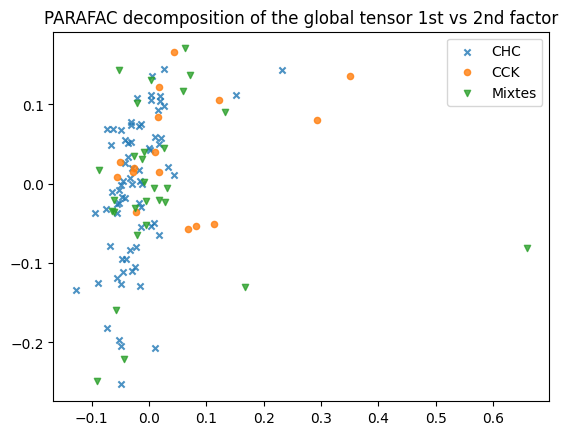

In [10]:
mask_chc = np.where(y == "CHC")
mask_cck = np.where(y == "CCK")
mask_mix = np.where(y == "Mixtes")

plt.figure()
plt.scatter(
    factors[0][mask_chc[0], 0],
    factors[0][mask_chc[0], 1],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
plt.scatter(
    factors[0][mask_cck[0], 0],
    factors[0][mask_cck[0], 1],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
plt.scatter(
    factors[0][mask_mix[0], 0],
    factors[0][mask_mix[0], 1],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# plt.xscale('log')
# plt.yscale('log')
plt.title("PARAFAC decomposition of the global tensor 1st vs 2nd factor")
plt.legend()
plt.show()

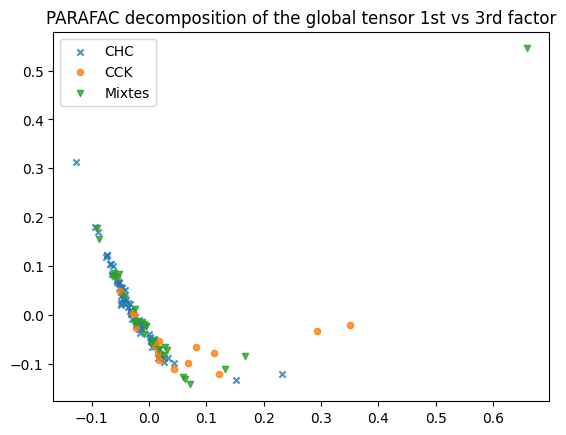

In [11]:
mask_chc = np.where(y == "CHC")
mask_cck = np.where(y == "CCK")
mask_mix = np.where(y == "Mixtes")

plt.figure()
plt.scatter(
    factors[0][mask_chc[0], 0],
    factors[0][mask_chc[0], 2],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
plt.scatter(
    factors[0][mask_cck[0], 0],
    factors[0][mask_cck[0], 2],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
plt.scatter(
    factors[0][mask_mix[0], 0],
    factors[0][mask_mix[0], 2],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# plt.xscale('log')
# plt.yscale('log')
plt.title("PARAFAC decomposition of the global tensor 1st vs 3rd factor")
plt.legend()
plt.show()

##### Time factors #####

The following graph describes the weights of the different phases on the results of the approximation of the data.

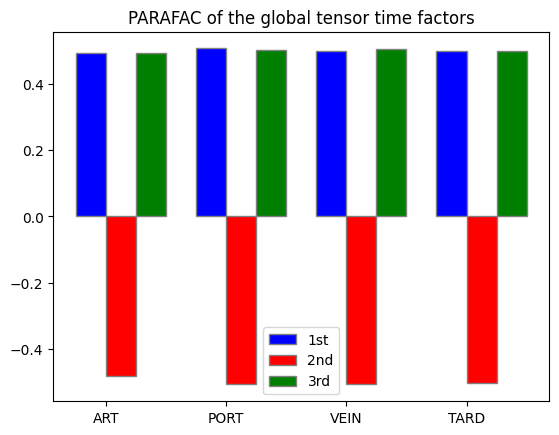

In [12]:
barWidth = 0.25

bar0 = factors[2][:, 0]
bar1 = factors[2][:, 1]
bar2 = factors[2][:, 2]

r1 = np.arange(len(bar0))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, bar0, color="b", width=barWidth, edgecolor="grey", label="1st")
plt.bar(r2, bar1, color="r", width=barWidth, edgecolor="grey", label="2nd")
plt.bar(r3, bar2, color="g", width=barWidth, edgecolor="grey", label="3rd")
plt.xticks(
    [r + barWidth / 2 for r in range(len(bar1))], ["ART", "PORT", "VEIN", "TARD"]
)
plt.legend()
plt.title("PARAFAC of the global tensor time factors")
plt.show()

Hard to analyse the time evolution even if it looks that ART phase is the least important but PORT, VEIN and TARD phase seem to have the same importance.

### Comparison with the median slice (3D tensor extracted from the 4D-tensor) ###

The median slice of the 4D tensor is extracted to have a similar format as before and see if it contains more information as the global tensor. So we did the same thing as before.

In [13]:
tensor_slice.shape

med_slice = tensor_slice[:, :, 1, :]
med_slice = med_slice.reshape((114, 95, 4))

y_med = med_slice[:, 0, 0]

X_med = med_slice[:, 2:, :]
X_med = (X_med - np.mean(X_med.astype(float), axis=0)) / np.std(
    X_med.astype(float), axis=0
)
X_med = ts.tensor(X_med).astype(float)

In [14]:
weights_med, factors_med = parafac(X_med, rank=3, normalize_factors=True)

print(weights_med.shape)
print(factors_med[0].shape)

(3,)
(114, 3)


#### Individual plan ####

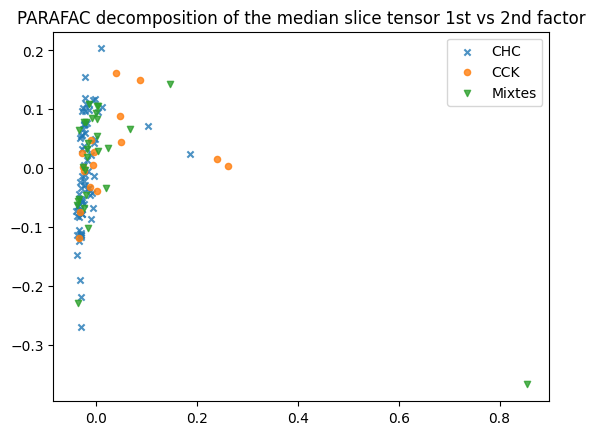

In [15]:
mask_chc_med = np.where(y_med == "CHC")
mask_cck_med = np.where(y_med == "CCK")
mask_mix_med = np.where(y_med == "Mixtes")

plt.scatter(
    factors_med[0][mask_chc_med[0], 0],
    factors_med[0][mask_chc_med[0], 1],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
plt.scatter(
    factors_med[0][mask_cck_med[0], 0],
    factors_med[0][mask_cck_med[0], 1],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
plt.scatter(
    factors_med[0][mask_mix_med[0], 0],
    factors_med[0][mask_mix_med[0], 1],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title("PARAFAC decomposition of the median slice tensor 1st vs 2nd factor")
plt.show()

#### Time factors ####

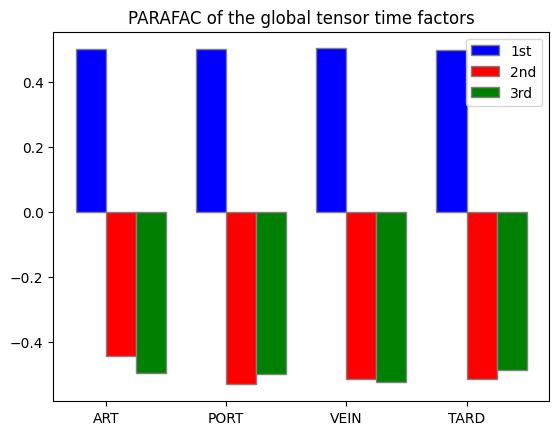

In [16]:
barWidth = 0.25

bar0 = factors_med[2][:, 0]
bar1 = factors_med[2][:, 1]
bar2 = factors_med[2][:, 2]

r1 = np.arange(len(bar0))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, bar0, color="b", width=barWidth, edgecolor="grey", label="1st")
plt.bar(r2, bar1, color="r", width=barWidth, edgecolor="grey", label="2nd")
plt.bar(r3, bar2, color="g", width=barWidth, edgecolor="grey", label="3rd")
plt.xticks(
    [r + barWidth / 2 for r in range(len(bar1))], ["ART", "PORT", "VEIN", "TARD"]
)
plt.legend()
plt.title("PARAFAC of the global tensor time factors")
plt.show()

It looks coherent with what we have seen before with the ART phase being the least important phase (particularly for the red factor).

#### Comparison ####

We plotted the two individual plans to make the comparison easier.

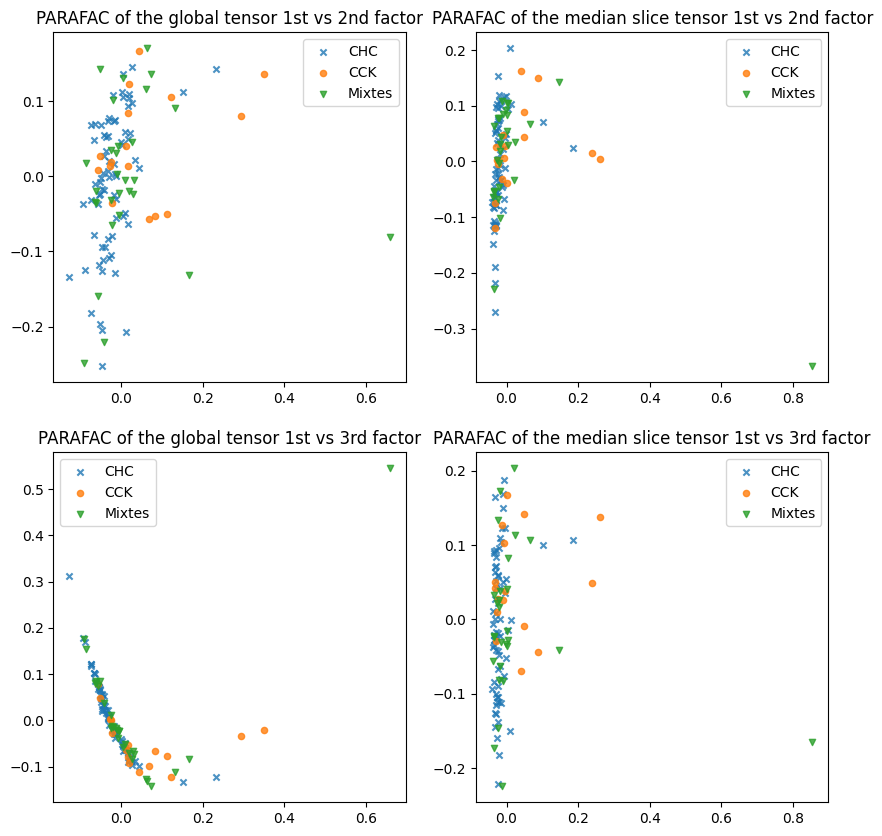

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].scatter(
    factors[0][mask_chc[0], 0],
    factors[0][mask_chc[0], 1],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[0, 0].scatter(
    factors[0][mask_cck[0], 0],
    factors[0][mask_cck[0], 1],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
ax[0, 0].scatter(
    factors[0][mask_mix[0], 0],
    factors[0][mask_mix[0], 1],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
ax[0, 0].legend()
ax[0, 0].set_title("PARAFAC of the global tensor 1st vs 2nd factor")

ax[0, 1].scatter(
    factors_med[0][mask_chc_med[0], 0],
    factors_med[0][mask_chc_med[0], 1],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[0, 1].scatter(
    factors_med[0][mask_cck_med[0], 0],
    factors_med[0][mask_cck_med[0], 1],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
ax[0, 1].scatter(
    factors_med[0][mask_mix_med[0], 0],
    factors_med[0][mask_mix_med[0], 1],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax[0, 1].legend()
ax[0, 1].set_title("PARAFAC of the median slice tensor 1st vs 2nd factor")

ax[1, 0].scatter(
    factors[0][mask_chc[0], 0],
    factors[0][mask_chc[0], 2],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[1, 0].scatter(
    factors[0][mask_cck[0], 0],
    factors[0][mask_cck[0], 2],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
ax[1, 0].scatter(
    factors[0][mask_mix[0], 0],
    factors[0][mask_mix[0], 2],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
ax[1, 0].legend()
ax[1, 0].set_title("PARAFAC of the global tensor 1st vs 3rd factor")

ax[1, 1].scatter(
    factors_med[0][mask_chc_med[0], 0],
    factors_med[0][mask_chc_med[0], 2],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[1, 1].scatter(
    factors_med[0][mask_cck_med[0], 0],
    factors_med[0][mask_cck_med[0], 2],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
ax[1, 1].scatter(
    factors_med[0][mask_mix_med[0], 0],
    factors_med[0][mask_mix_med[0], 2],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax[1, 1].legend()
ax[1, 1].set_title("PARAFAC of the median slice tensor 1st vs 3rd factor")


plt.show()

#### Comparison (zoomed version) ####

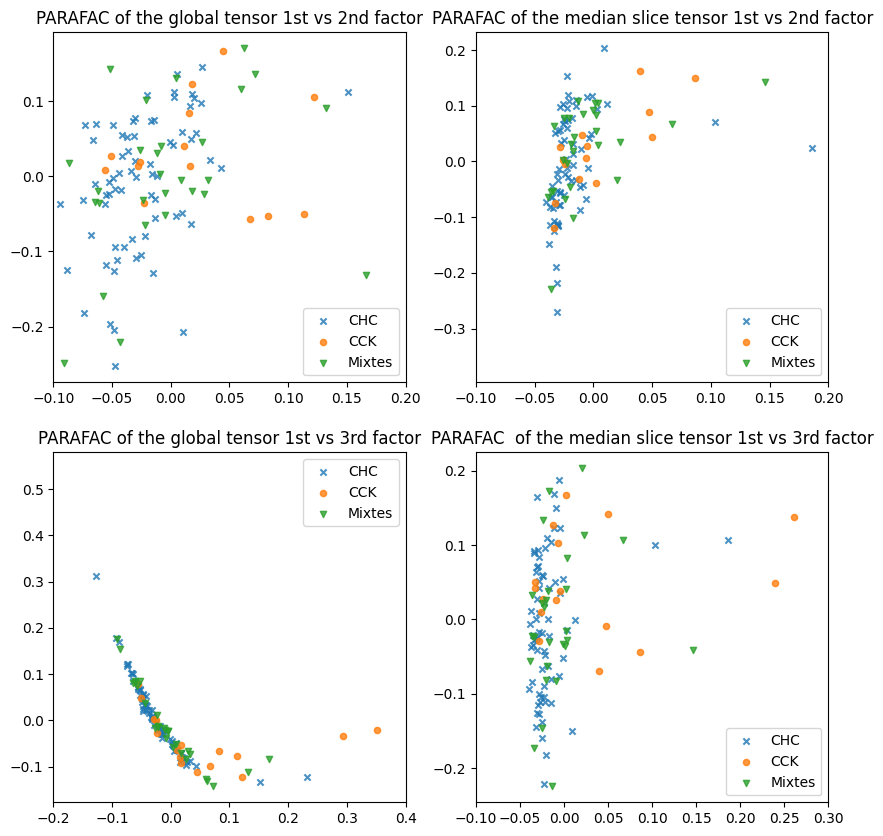

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].scatter(
    factors[0][mask_chc[0], 0],
    factors[0][mask_chc[0], 1],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[0, 0].scatter(
    factors[0][mask_cck[0], 0],
    factors[0][mask_cck[0], 1],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
ax[0, 0].scatter(
    factors[0][mask_mix[0], 0],
    factors[0][mask_mix[0], 1],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
ax[0, 0].set_xlim(-0.1, 0.2)
ax[0, 0].legend()
ax[0, 0].set_title("PARAFAC of the global tensor 1st vs 2nd factor")

ax[0, 1].scatter(
    factors_med[0][mask_chc_med[0], 0],
    factors_med[0][mask_chc_med[0], 1],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[0, 1].scatter(
    factors_med[0][mask_cck_med[0], 0],
    factors_med[0][mask_cck_med[0], 1],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
ax[0, 1].scatter(
    factors_med[0][mask_mix_med[0], 0],
    factors_med[0][mask_mix_med[0], 1],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax[0, 1].set_xlim(-0.1, 0.2)
ax[0, 1].legend()
ax[0, 1].set_title("PARAFAC of the median slice tensor 1st vs 2nd factor")

ax[1, 0].scatter(
    factors[0][mask_chc[0], 0],
    factors[0][mask_chc[0], 2],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[1, 0].scatter(
    factors[0][mask_cck[0], 0],
    factors[0][mask_cck[0], 2],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
ax[1, 0].scatter(
    factors[0][mask_mix[0], 0],
    factors[0][mask_mix[0], 2],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
ax[1, 0].set_xlim(-0.2, 0.4)
ax[1, 0].legend()
ax[1, 0].set_title("PARAFAC of the global tensor 1st vs 3rd factor")

ax[1, 1].scatter(
    factors_med[0][mask_chc_med[0], 0],
    factors_med[0][mask_chc_med[0], 2],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[1, 1].scatter(
    factors_med[0][mask_cck_med[0], 0],
    factors_med[0][mask_cck_med[0], 2],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
ax[1, 1].scatter(
    factors_med[0][mask_mix_med[0], 0],
    factors_med[0][mask_mix_med[0], 2],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax[1, 1].set_xlim(-0.1, 0.3)
ax[1, 1].legend()
ax[1, 1].set_title("PARAFAC  of the median slice tensor 1st vs 3rd factor")


plt.show()

#### Comparison (zoomed + without Mixtes) ####

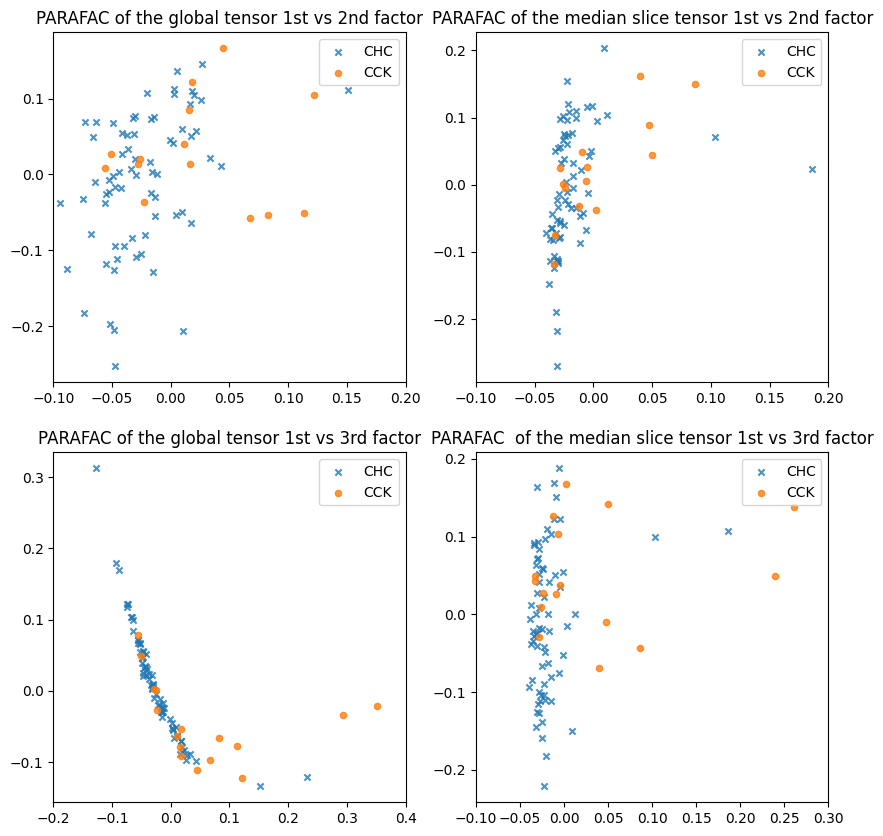

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].scatter(
    factors[0][mask_chc[0], 0],
    factors[0][mask_chc[0], 1],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[0, 0].scatter(
    factors[0][mask_cck[0], 0],
    factors[0][mask_cck[0], 1],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
# ax[0,0].scatter(factors[0][mask_mix[0],0],factors[0][mask_mix[0],1],label = 'Mixtes',s=20,alpha=0.8,marker='v')
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
ax[0, 0].set_xlim(-0.1, 0.2)
ax[0, 0].legend()
ax[0, 0].set_title("PARAFAC of the global tensor 1st vs 2nd factor")

ax[0, 1].scatter(
    factors_med[0][mask_chc_med[0], 0],
    factors_med[0][mask_chc_med[0], 1],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[0, 1].scatter(
    factors_med[0][mask_cck_med[0], 0],
    factors_med[0][mask_cck_med[0], 1],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
# ax[0,1].scatter(factors_med[0][mask_mix[0],0],factors_med[0][mask_mix[0],1],label = 'Mixtes',s=20,alpha=0.8,marker='v')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax[0, 1].set_xlim(-0.1, 0.2)
ax[0, 1].legend()
ax[0, 1].set_title("PARAFAC of the median slice tensor 1st vs 2nd factor")

ax[1, 0].scatter(
    factors[0][mask_chc[0], 0],
    factors[0][mask_chc[0], 2],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[1, 0].scatter(
    factors[0][mask_cck[0], 0],
    factors[0][mask_cck[0], 2],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
# ax[1,0].scatter(factors[0][mask_mix[0],0],factors[0][mask_mix[0],2],label = 'Mixtes',s=20,alpha=0.8,marker='v')
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
ax[1, 0].set_xlim(-0.2, 0.4)
ax[1, 0].legend()
ax[1, 0].set_title("PARAFAC of the global tensor 1st vs 3rd factor")

ax[1, 1].scatter(
    factors_med[0][mask_chc_med[0], 0],
    factors_med[0][mask_chc_med[0], 2],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[1, 1].scatter(
    factors_med[0][mask_cck_med[0], 0],
    factors_med[0][mask_cck_med[0], 2],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
# ax[1,1].scatter(factors_med[0][mask_mix[0],0],factors_med[0][mask_mix[0],2],label = 'Mixtes',s=20,alpha=0.8,marker='v')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax[1, 1].set_xlim(-0.1, 0.3)
ax[1, 1].legend()
ax[1, 1].set_title("PARAFAC  of the median slice tensor 1st vs 3rd factor")


plt.show()

Finally, the principal plan is not really different from one tensor to the other even if the visualisation from the global tensor is slighlty better.

### Slice (4D-tensor) ###

Here we are using the full tensor with the spatial information as a new factor (for more information about the spatial factor see extraction_and_save notebook).

In [20]:
X_slice = tensor_slice[:, 2:, :, :] #Remove labels and slice_number
X_slice.shape

X_slice = (X_slice - np.mean(X_slice.astype(float), axis=0)) / np.std(
    X_slice.astype(float), axis=0
)


y_slice = tensor_slice[:, 0, 0, 0]

X_slice = ts.tensor(X_slice).astype(float)

In [21]:
weights_slice, factors_slice = parafac(X_slice, rank=3, normalize_factors=True)

print(weights_slice.shape)
print(factors_slice[3].shape)

(3,)
(4, 3)


#### Individual Plan ####

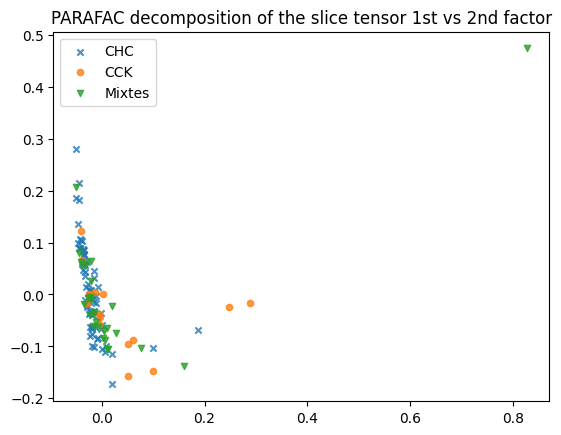

In [22]:
mask_chc_slice = np.where(y_slice == "CHC")
mask_cck_slice = np.where(y_slice == "CCK")
mask_mix_slice = np.where(y_slice == "Mixtes")

plt.scatter(
    factors_slice[0][mask_chc_slice[0], 0],
    factors_slice[0][mask_chc_slice[0], 1],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
plt.scatter(
    factors_slice[0][mask_cck_slice[0], 0],
    factors_slice[0][mask_cck_slice[0], 1],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
plt.scatter(
    factors_slice[0][mask_mix_slice[0], 0],
    factors_slice[0][mask_mix_slice[0], 1],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title("PARAFAC decomposition of the slice tensor 1st vs 2nd factor")
plt.show()

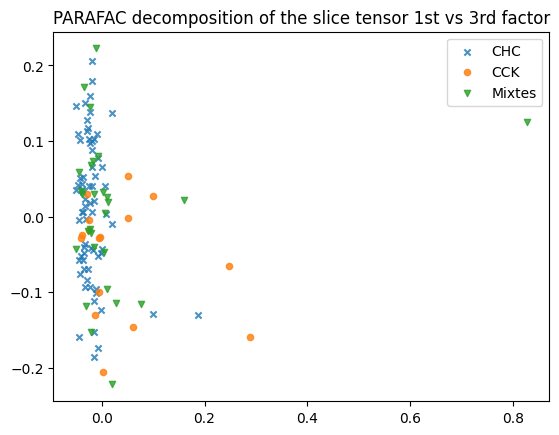

In [23]:
plt.scatter(
    factors_slice[0][mask_chc_slice[0], 0],
    factors_slice[0][mask_chc_slice[0], 2],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
plt.scatter(
    factors_slice[0][mask_cck_slice[0], 0],
    factors_slice[0][mask_cck_slice[0], 2],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
plt.scatter(
    factors_slice[0][mask_mix_slice[0], 0],
    factors_slice[0][mask_mix_slice[0], 2],
    label="Mixtes",
    s=20,
    alpha=0.8,
    marker="v",
)
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title("PARAFAC decomposition of the slice tensor 1st vs 3rd factor")
plt.show()

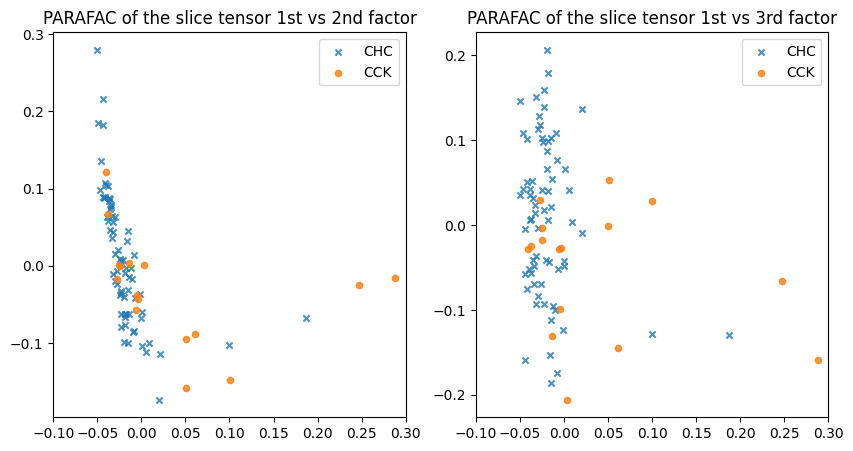

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(
    factors_slice[0][mask_chc_slice[0], 0],
    factors_slice[0][mask_chc_slice[0], 1],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[0].scatter(
    factors_slice[0][mask_cck_slice[0], 0],
    factors_slice[0][mask_cck_slice[0], 1],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
# ax[0].scatter(factors_slice[0][mask_mix[0],0],factors_slice[0][mask_mix[0],1],label = 'Mixtes',s=20,alpha=0.8,marker='v')
ax[0].set_xlim(-0.1, 0.3)
ax[0].legend()
ax[0].set_title("PARAFAC of the slice tensor 1st vs 2nd factor")

ax[1].scatter(
    factors_slice[0][mask_chc_slice[0], 0],
    factors_slice[0][mask_chc_slice[0], 2],
    label="CHC",
    s=20,
    alpha=0.8,
    marker="x",
)
ax[1].scatter(
    factors_slice[0][mask_cck_slice[0], 0],
    factors_slice[0][mask_cck_slice[0], 2],
    label="CCK",
    s=20,
    alpha=0.8,
    marker="o",
)
# ax[1].scatter(factors_slice[0][mask_mix[0],0],factors_slice[0][mask_mix[0],2],label = 'Mixtes',s=20,alpha=0.8,marker='v')
ax[1].set_xlim(-0.1, 0.3)
ax[1].legend()
ax[1].set_title("PARAFAC of the slice tensor 1st vs 3rd factor")

plt.show()

As one can see the difference is not huge for the individual plan compared to the previous version, we still have a small trend right/left for the principal plan for the classification CCK vs CHC.

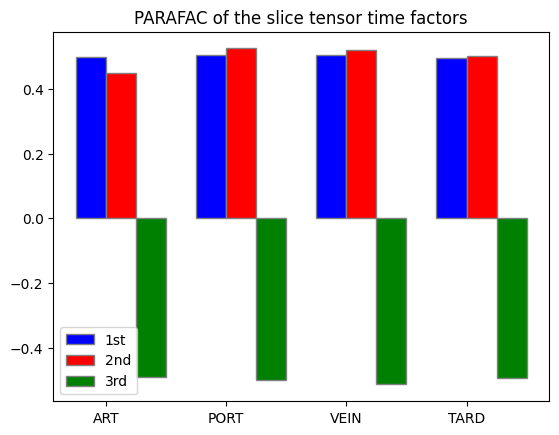

In [26]:
barWidth = 0.25

bar0 = factors_slice[3][:, 0]
bar1 = factors_slice[3][:, 1]
bar2 = factors_slice[3][:, 2]

r1 = np.arange(len(bar0))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, bar0, color="b", width=barWidth, edgecolor="grey", label="1st")
plt.bar(r2, bar1, color="r", width=barWidth, edgecolor="grey", label="2nd")
plt.bar(r3, bar2, color="g", width=barWidth, edgecolor="grey", label="3rd")
plt.xticks(
    [r + barWidth / 2 for r in range(len(bar1))], ["ART", "PORT", "VEIN", "TARD"]
)
plt.legend()
plt.title("PARAFAC of the slice tensor time factors")
plt.show()

Once again, the difference is not huge but it looks like the ART phase does not seem to be the most important and also the TARD phase which seems relevant with what we heard about the IRM process.

##### Space factor #####

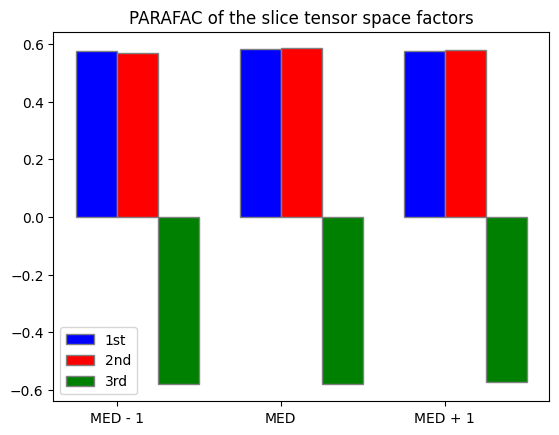

In [27]:
barWidth = 0.25

bar0 = factors_slice[2][:, 0]
bar1 = factors_slice[2][:, 1]
bar2 = factors_slice[2][:, 2]

r1 = np.arange(len(bar0))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, bar0, color="b", width=barWidth, edgecolor="grey", label="1st")
plt.bar(r2, bar1, color="r", width=barWidth, edgecolor="grey", label="2nd")
plt.bar(r3, bar2, color="g", width=barWidth, edgecolor="grey", label="3rd")
plt.xticks([r + barWidth / 2 for r in range(len(bar1))], ["MED - 1", "MED", "MED + 1"])
plt.legend()
plt.title("PARAFAC of the slice tensor space factors")
plt.show()

As expected, there is not a lot of difference between the slices for a patient which seems normal as we chose contiguous slices for a patient. One can ask if we should have not chose the first, the median and the last slice for each patient but for most patient they only have 3 slices so it would have been the same.

### Prediction using tensored data with Multiway Logistic Regression ###

In the same way as before, we will test the different tensors (global, median slice and slice) combined with a Multiway Logistic Regression to classify the different tumors. Since the method is flexible for a L2 or L1 penalty, we will try both each time because the selection of the variables is a huge stake in this kind of problems.

In this section, we will try to do some prediction on the cancer class (mainly between CHC vs CCK or CHC vs others) using multiway logistic regression. The implementation have been discusses in the final report and relied on the sklearn module to do the easy logistic regression.

In [28]:
from sklearn.linear_model import LogisticRegression


class MultiwayLogisticRegression:
    def __init__(self, X, y, penalty, tol=1e-4, lambda_0=0.01, max_iter=250):
        """
        Args:
            X (np.array): The features in a form of a 3D tensor
            y (np.array): The labels
            penalty (str): The penalty to use for the logistic regression must be 'l1' or 'l2'
            tol (float): The tolerance for the stopping criterion
            lambda_0 (float): The regularization parameter
            max_iter (int): The maximum number of iterations
        """
        self.X = X
        self.y = y
        self.tol = tol
        self.lambda_0 = lambda_0
        self.max_iter = max_iter
        self.I, self.J, self.K = X.shape
        self.N = self.I
        self.w_0 = None
        self.w_K = None
        self.w_J = None
        self.penalty = penalty

    def get_features(self):
        return self.X

    def get_labels(self):
        return self.y

    def get_dimensions(self):
        return X.shape

    def get_weights(self):
        return self.w_0, self.w_K, self.w_J

    def logistic_reg(self, X, y, lambda_reg):
        clf = LogisticRegression(
            random_state=0,
            fit_intercept=True,
            penalty=self.penalty,
            solver="liblinear",
            C=1 / lambda_reg * self.lambda_0,
        ).fit(X, y)
        return clf.intercept_, clf.coef_[0]

    def fit(self):
        self.w_K = np.random.normal(1, 1 / self.K, self.K)
        self.w_K /= np.linalg.norm(self.w_K, ord=2)
        has_converged = False
        q = 0
        does_not_move_since = 0
        while not has_converged and q < self.max_iter:
            w_K_old = self.w_K
            x_iK = np.zeros((self.N, self.J))
            for k in range(self.K):
                for i in range(self.N):
                    x_iK[i, :] += self.X[i, :, k] * self.w_K[k]
            assert x_iK.shape == (self.N, self.J)
            self.w_0, self.w_J = self.logistic_reg(
                x_iK, self.y, np.linalg.norm(self.w_K, ord=2) ** 2
            )

            x_iJ = np.zeros((self.N, self.K))
            for j in range(self.J):
                for i in range(self.N):
                    x_iJ[i, :] += self.X[i, j, :] * self.w_J[j]
            assert x_iJ.shape == (self.N, self.K)

            self.w_0, self.w_K = self.logistic_reg(
                x_iJ, self.y, np.linalg.norm(self.w_J, ord=2) ** 2
            )
            self.w_K /= np.linalg.norm(self.w_K, ord=2)

            q += 1
            if np.linalg.norm(self.w_K - w_K_old, ord=2) < self.tol:
                if does_not_move_since > 10:
                    has_converged = True
                else:
                    does_not_move_since += 1
            else:
                does_not_move_since = 0

        print(
            "Norm between the last two steps : ",
            np.linalg.norm(self.w_K - w_K_old, ord=2),
        )
        print("Number of iterations : ", q)
        return self.w_0, self.w_K, self.w_J

    def predict_proba(self, X_test, w_0, w_K, w_J):
        exponent = (
            w_0
            + np.kron(w_J, w_K).T @ X_test.reshape((X_test.shape[0], self.J * self.K)).T
        )
        proba = np.exp(exponent) / (1 + np.exp(exponent))
        return proba

    def fit_predict(self, X_test):
        w_0, w_K, w_J = self.fit()
        threshold = self.find_threshold(w_0, w_K, w_J)
        proba = self.predict_proba(X_test, w_0, w_K, w_J)
        return proba > threshold

    def predict(self, X_test, w_0, w_K, w_J, threshold=0.5):
        proba = self.predict_proba(X_test, w_0, w_K, w_J)
        return proba > threshold

    def find_threshold(self, w_0, w_K, w_J):
        """
        Args:
            w_0 (np.array): The intercept
            w_K (np.array): The weights for the K dimension (time)
            w_J (np.array): The weights for the J dimension (features)

        Returns :
            The threshold that maximizes the balanced accuracy on the training set
        """
        best_threshold = 0
        best_score = 0
        for threshold in np.linspace(0.001, 1 - 0.001, 100):
            y_pred = self.predict(self.X, w_0, w_K, w_J, threshold)
            tp = np.sum(np.logical_and(y_pred == True, self.y == True))
            tn = np.sum(np.logical_and(y_pred == False, self.y == False))
            fp = np.sum(np.logical_and(y_pred == True, self.y == False))
            fn = np.sum(np.logical_and(y_pred == False, self.y == True))
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
            f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)
            score = balanced_accuracy
            if score > best_score:
                best_score = score
                best_threshold = threshold

        print("Best threshold found : ", best_threshold)
        print("Best score found : ", best_score)
        return best_threshold

    def area_under_curve(self, X_test, y_test):
        tpr_list = []
        fpr_list = []
        w_0, w_K, w_J = self.fit()
        proba = self.predict_proba(X_test, w_0, w_K, w_J)
        for threshold in np.linspace(0, 1, 100):
            y_pred = self.predict(X_test, w_0, w_K, w_J, threshold)
            tp = np.sum(np.logical_and(y_pred == True, y_test == True))
            tn = np.sum(np.logical_and(y_pred == False, y_test == False))
            fp = np.sum(np.logical_and(y_pred == True, y_test == False))
            fn = np.sum(np.logical_and(y_pred == False, y_test == True))
            tpr = tp / (tp + fn)
            fpr = fp / (fp + tn)
            tpr_list.append(tpr)
            fpr_list.append(fpr)
        plt.plot(fpr_list, tpr_list)
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title("ROC curve")
        plt.show()

Some testing.

In [30]:
X = tensor_global[:, 1:, :]
mask_cck_chc = np.where((y == "CHC") | (y == "CCK"))

X = X[mask_cck_chc[0], :, :]
y = y[mask_cck_chc[0]]

X.shape

(88, 107, 4)

Text(0.5, 1.0, 'Number of tumors in each class')

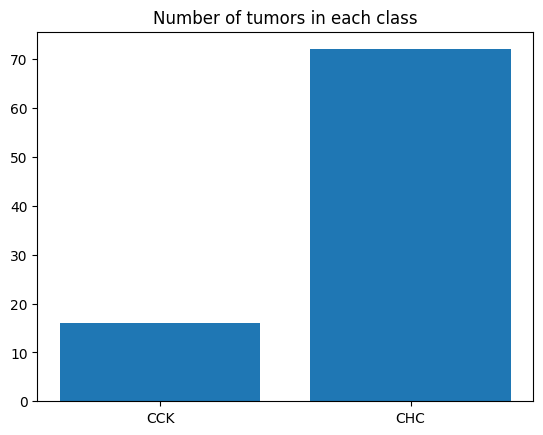

In [31]:
# Bar plot for number of tumors in each class

unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)
plt.title("Number of tumors in each class")

In [32]:
print(len(np.where(y == "CHC")[0]))
print(len(np.where(y == "CCK")[0]))

72
16


In [33]:
# I want the first 54 CHC tumors and first 12 CCK tumors to be in the training set

train_indices = np.concatenate(
    (np.where(y == "CHC")[0][:54], np.where(y == "CCK")[0][:12])
)

X_train = X[train_indices, :, :]
y_train = y[train_indices]

X_test = np.delete(X, train_indices, axis=0)
y_test = np.delete(y, train_indices)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = (X_train - np.mean(X_train.astype(float), axis=0)) / np.std(
    X_train.astype(float), axis=0
)
X_train = X_train.astype(float)

X_test = (X_test - np.mean(X_test.astype(float), axis=0)) / np.std(
    X_test.astype(float), axis=0
)
X_test = X_test.astype(float)

(66, 107, 4)
(66,)
(22, 107, 4)
(22,)


In [34]:
dic_label = {"CHC": 0, "CCK": 1}
y_train = np.array([dic_label[y] for y in y_train])
y_test = np.array([dic_label[y] for y in y_test])
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
# Shuffle the training set

indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)

X_train = X_train[indices_train, :, :]
y_train = y_train[indices_train]

y_train

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [36]:
# Shuffle the test set

indices_test = np.arange(X_test.shape[0])
np.random.shuffle(indices_test)

X_test = X_test[indices_test, :, :]
y_test = y_test[indices_test]
y_test

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [37]:
clf = MultiwayLogisticRegression(X_train, y_train, "l1", 1e3, 10000, 1000)

y_pred = clf.fit_predict(X_test)


tp = np.sum(np.logical_and(y_pred == True, y_test == 1))
tn = np.sum(np.logical_and(y_pred == False, y_test == 0))
fp = np.sum(np.logical_and(y_pred == True, y_test == 0))
fn = np.sum(np.logical_and(y_pred == False, y_test == 1))

accuracy = (tp + tn) / (tp + tn + fp + fn)
balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)


print("Accuracy : ", accuracy)
print("Balanced accuracy : ", balanced_accuracy)
print("Sensitivity : ", sensitivity)
print("Specificity : ", specificity)
print("F1 score : ", f1_score)

Norm between the last two steps :  0.044615631169519374
Number of iterations :  12
Best threshold found :  0.15221212121212122
Best score found :  1.0
Accuracy :  0.45454545454545453
Balanced accuracy :  0.375
Sensitivity :  0.25
Specificity :  0.5
F1 score :  0.3333333333333333


#### K-Fold Cross-Validation #####

Considering the number of individuals, let's do some cross-validation using K-fold. K will be set to 2 when one class is CCK because there are only 16 patients with this type of tumors. When we classify CHC vs Others or CHC vs Mixtes, K will be set to 4. Each time, we will present the results and the coefficients for the time factor, feature factor and when available the space factor. For L1 penalty, we printed the selected features.

For the penalty parameter, we perfomred a small grid search to find what looked like the best parameter.

#### Global tensor ####

##### CHC vs CCK ######

L2 penalty

In [39]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where(y == "CCK")[0]
mask_chc = np.where(y == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l2", 1e-10, 1e-2, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  1.3597399555105182e-16
Number of iterations :  22
Best threshold found :  0.33366666666666667
Best score found :  0.8819444444444444
Accuracy :  0.8409090909090909
Balanced accuracy :  0.7083333333333333
Sensitivity :  0.5
Specificity :  0.9166666666666666
F1 score :  0.6470588235294118


FOLD 2
Norm between the last two steps :  1.5700924586837751e-15
Number of iterations :  34
Best threshold found :  0.24293939393939395
Best score found :  0.8680555555555556
Accuracy :  0.6363636363636364
Balanced accuracy :  0.6805555555555556
Sensitivity :  0.75
Specificity :  0.6111111111111112
F1 score :  0.6734693877551021


In [40]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.7386363636363636
+/-
0.10227272727272729
Mean balanced accuracy :  0.6944444444444444
+/-
0.01388888888888884
Mean sensitivity :  0.625
+/-
0.125
Mean specificity :  0.625
+/-
0.125
Mean f1 score :  0.6602641056422569
+/-
0.013205282112845163


(None, None, None)

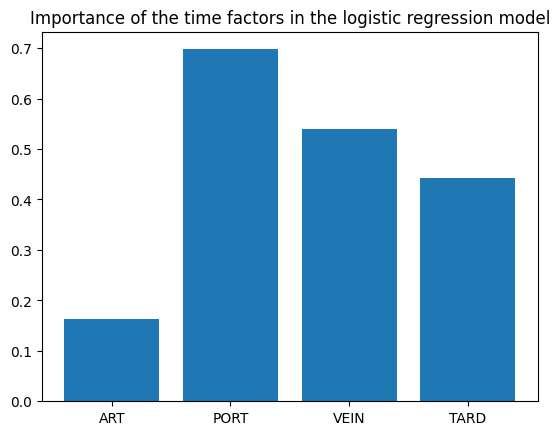

In [41]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

Coherent with what has been described by the doctor and the PARAFAC technique.

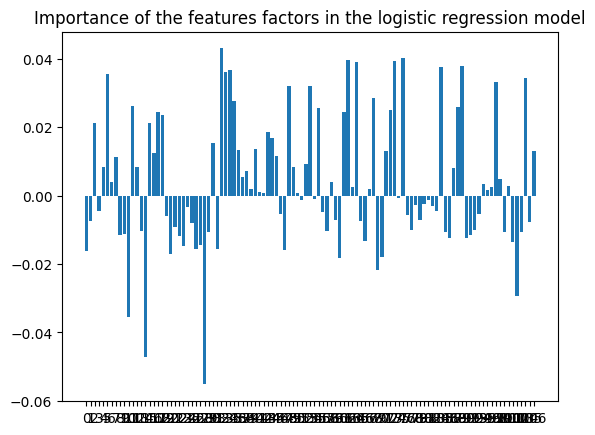

In [42]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

L1 penalty

In [43]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where(y == "CCK")[0]
mask_chc = np.where(y == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l1", 1e-6, 1e3, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  0.0047655465892307075
Number of iterations :  1000
Best threshold found :  0.8477878787878788
Best score found :  1.0
Accuracy :  0.7727272727272727
Balanced accuracy :  0.7152777777777778
Sensitivity :  0.625
Specificity :  0.8055555555555556
F1 score :  0.7038834951456311


FOLD 2
Norm between the last two steps :  0.0045884739852623995
Number of iterations :  1000
Best threshold found :  0.12196969696969698
Best score found :  1.0
Accuracy :  0.6590909090909091
Balanced accuracy :  0.5972222222222222
Sensitivity :  0.5
Specificity :  0.6944444444444444
F1 score :  0.5813953488372093


In [44]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.7159090909090908
+/-
0.05681818181818182
Mean balanced accuracy :  0.65625
+/-
0.05902777777777779
Mean sensitivity :  0.5625
+/-
0.0625
Mean specificity :  0.5625
+/-
0.0625
Mean f1 score :  0.6426394219914202
+/-
0.061244073154210876


(None, None, None)

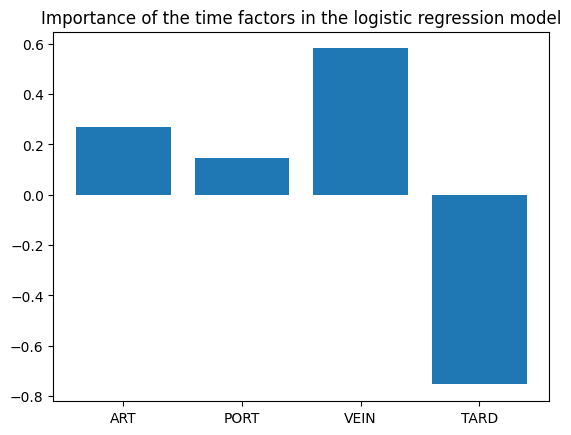

In [45]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

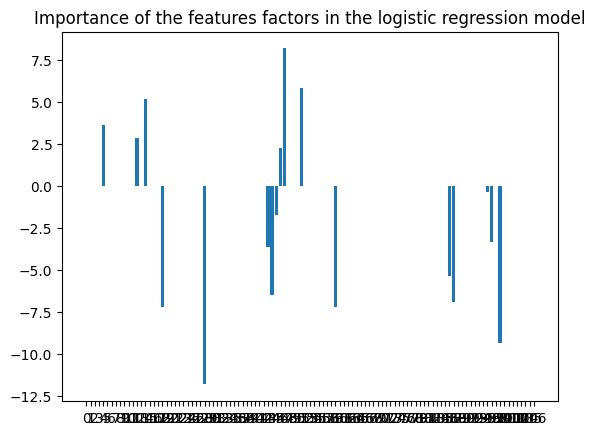

In [46]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

In [47]:
print("Selected Features : ")
for i in range(len(w_J)):
    if w_J[i] != 0:
        print(dic_global[i])

Selected Features : 
original_firstorder_InterquartileRange
original_firstorder_Kurtosis
original_firstorder_RobustMeanAbsoluteDeviation
original_firstorder_Skewness
original_shape_Elongation
original_shape_Sphericity
original_glcm_Idmn
original_glcm_Idn
original_glcm_Imc1
original_glcm_Imc2
original_glcm_InverseVariance
original_glcm_MCC
original_gldm_DependenceVariance
original_glszm_GrayLevelNonUniformity
original_glszm_GrayLevelNonUniformityNormalized
original_glszm_SizeZoneNonUniformityNormalized
original_glszm_SmallAreaEmphasis
original_glszm_SmallAreaLowGrayLevelEmphasis


##### Mixtes vs CHC ######

In [48]:
X = tensor_global[:, 1:, :]
y = tensor_global[:, 0, 0]
y

array(['CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK',
       'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'Mixtes',
       'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes',
       'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes',
       'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes',
       'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes',
       'Mixtes', 'Mixtes', 'Mixtes',

L2 penalty 

In [49]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where(y == "Mixtes")[0]
mask_chc = np.where(y == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l2", 1e-10, 1e0, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  3.075709422651989e-11
Number of iterations :  241
Best threshold found :  0.43447474747474746
Best score found :  0.876984126984127
Accuracy :  0.6923076923076923
Balanced accuracy :  0.6736111111111112
Sensitivity :  0.625
Specificity :  0.7222222222222222
F1 score :  0.6701030927835051


FOLD 2
Norm between the last two steps :  4.2486413783477435e-08
Number of iterations :  1000
Best threshold found :  0.4243939393939394
Best score found :  0.9494949494949495
Accuracy :  0.6
Balanced accuracy :  0.503968253968254
Sensitivity :  0.2857142857142857
Specificity :  0.7222222222222222
F1 score :  0.4094488188976378


FOLD 3
Norm between the last two steps :  1.9449588715043408e-10
Number of iterations :  1000
Best threshold found :  0.6058484848484849
Best score found :  0.9225589225589226
Accuracy :  0.6
Balanced accuracy :  0.5476190476190476
Sensitivity :  0.42857142857142855
Specificity :  0.6666666666666666
F1 score :  0.5217391304347826



In [50]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.6230769230769231
+/-
0.03997040325158948
Mean balanced accuracy :  0.568204365079365
+/-
0.06341208613025623
Mean sensitivity :  0.4419642857142857
+/-
0.120700944951748
Mean specificity :  0.4419642857142857
+/-
0.120700944951748
Mean f1 score :  0.5307575431376771
+/-
0.09259542688249145


(None, None, None)

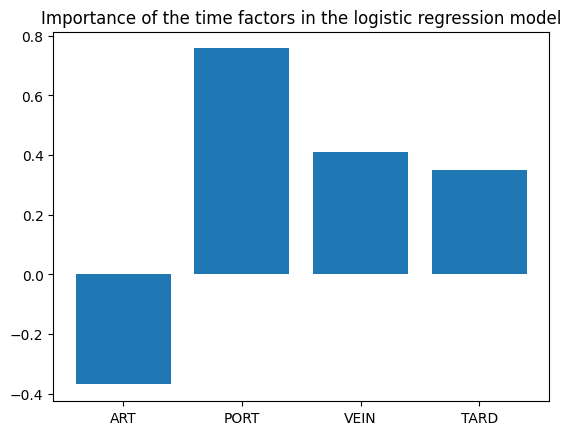

In [51]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

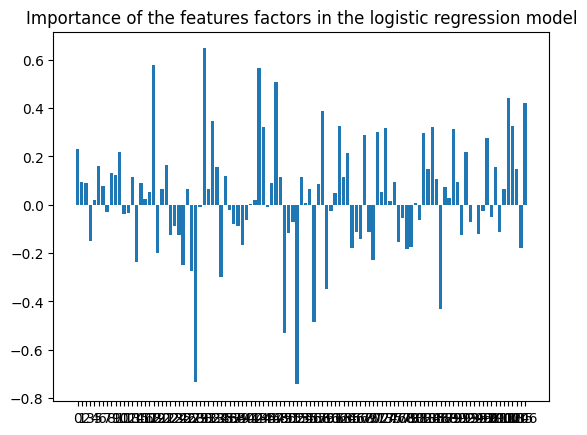

In [52]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

L1 penalty

In [53]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where(y == "Mixtes")[0]
mask_chc = np.where(y == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l1", 1e-10, 1e2, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  0.0015587192317030978
Number of iterations :  1000
Best threshold found :  0.999
Best score found :  0.9166666666666667
Accuracy :  0.6923076923076923
Balanced accuracy :  0.6736111111111112
Sensitivity :  0.625
Specificity :  0.7222222222222222
F1 score :  0.6701030927835051


FOLD 2
Norm between the last two steps :  0.0012094109186242266
Number of iterations :  1000
Best threshold found :  0.28326262626262627
Best score found :  1.0
Accuracy :  0.56
Balanced accuracy :  0.5198412698412699
Sensitivity :  0.42857142857142855
Specificity :  0.6111111111111112
F1 score :  0.5038167938931297


FOLD 3
Norm between the last two steps :  0.001487121800777937
Number of iterations :  1000
Best threshold found :  0.9788383838383838
Best score found :  1.0
Accuracy :  0.6
Balanced accuracy :  0.5912698412698413
Sensitivity :  0.5714285714285714
Specificity :  0.6111111111111112
F1 score :  0.5906040268456376


FOLD 4
Norm between the last two steps : 

In [54]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.6130769230769231
+/-
0.04857130426119041
Mean balanced accuracy :  0.6049107142857143
+/-
0.05710346674065161
Mean sensitivity :  0.5848214285714286
+/-
0.10364452469860626
Mean specificity :  0.5848214285714286
+/-
0.10364452469860626
Mean f1 score :  0.5973809783805681
+/-
0.06093336518147244


(None, None, None)

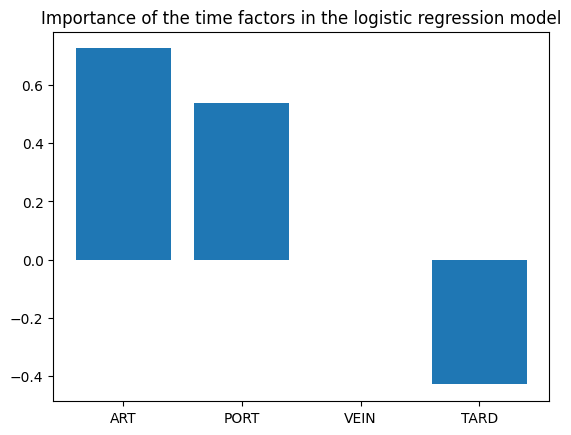

In [55]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

Sometimes the L1 penalty has some results that are quite surprising like thus one where the ART phase seems to have more importance and more importantly the VEIN phase is useless.

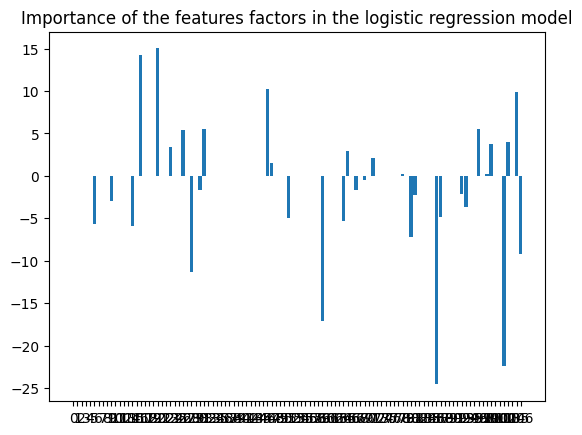

In [56]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

In [57]:
print("Selected Features : ")
for i in range(len(w_J)):
    if w_J[i] != 0:
        print(dic_global[i])

Selected Features : 
original_firstorder_Kurtosis
original_firstorder_Median
original_firstorder_Skewness
original_firstorder_Uniformity
original_shape_LeastAxisLength
original_shape_Maximum2DDiameterRow
original_shape_MeshVolume
original_shape_Sphericity
original_shape_SurfaceVolumeRatio
original_shape_VoxelVolume
original_glcm_Imc2
original_glcm_InverseVariance
original_glcm_MCC
original_gldm_DependenceVariance
original_gldm_LargeDependenceHighGrayLevelEmphasis
original_gldm_LargeDependenceLowGrayLevelEmphasis
original_gldm_SmallDependenceEmphasis
original_gldm_SmallDependenceLowGrayLevelEmphasis
original_glrlm_GrayLevelNonUniformityNormalized
original_glrlm_RunEntropy
original_glrlm_RunLengthNonUniformityNormalized
original_glrlm_RunPercentage
original_glszm_GrayLevelNonUniformity
original_glszm_GrayLevelNonUniformityNormalized
original_glszm_LargeAreaLowGrayLevelEmphasis
original_glszm_LowGrayLevelZoneEmphasis
original_glszm_SmallAreaEmphasis
original_glszm_SmallAreaLowGrayLevelEmp

##### CHC vs Others #####

In [58]:
X = tensor_global[:, 1:, :]
y = tensor_global[:, 0, 0]
y

array(['CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC', 'CHC',
       'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK',
       'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'CCK', 'Mixtes',
       'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes',
       'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes',
       'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes',
       'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes', 'Mixtes',
       'Mixtes', 'Mixtes', 'Mixtes',

L2 penalty

In [59]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y == "Mixtes") | (y == "CCK"))[0]
mask_chc = np.where(y == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l2", 1e-10, 1e-3, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  2.7755575615628914e-16
Number of iterations :  22
Best threshold found :  0.38407070707070706
Best score found :  0.6792929292929293
Accuracy :  0.7
Balanced accuracy :  0.6805555555555556
Sensitivity :  0.5833333333333334
Specificity :  0.7777777777777778
F1 score :  0.6666666666666666


FOLD 2
Norm between the last two steps :  3.188872858294072e-16
Number of iterations :  19
Best threshold found :  0.44455555555555554
Best score found :  0.7331154684095861
Accuracy :  0.5862068965517241
Balanced accuracy :  0.5429292929292929
Sensitivity :  0.36363636363636365
Specificity :  0.7222222222222222
F1 score :  0.4837209302325582


FOLD 3
Norm between the last two steps :  1.7554167342883506e-16
Number of iterations :  25
Best threshold found :  0.4243939393939394
Best score found :  0.6851851851851851
Accuracy :  0.8275862068965517
Balanced accuracy :  0.7904040404040404
Sensitivity :  0.6363636363636364
Specificity :  0.9444444444444444
F1 sco

In [60]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.7267241379310344
+/-
0.09359306126907598
Mean balanced accuracy :  0.6985479797979799
+/-
0.09957701439840601
Mean sensitivity :  0.5776515151515151
+/-
0.1338547612430653
Mean specificity :  0.5776515151515151
+/-
0.1338547612430653
Mean f1 score :  0.671867503151727
+/-
0.11645910447326532


(None, None, None)

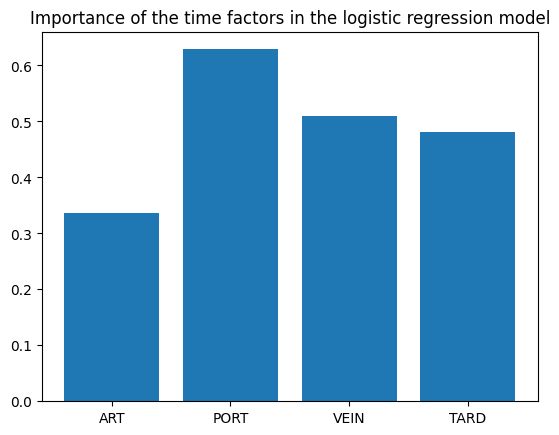

In [61]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

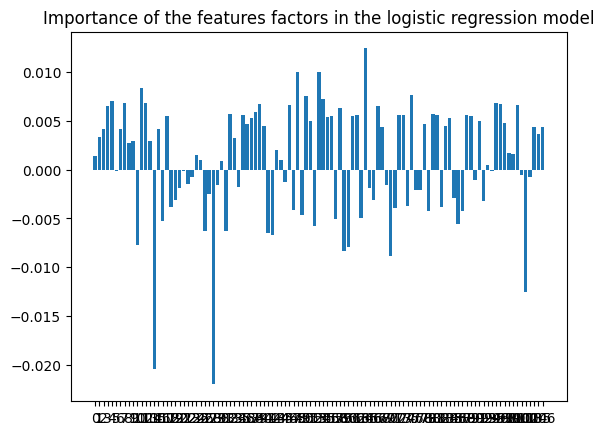

In [62]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

L1 penalty

In [63]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y == "Mixtes") | (y == "CCK"))[0]
mask_chc = np.where(y == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l1", 1e-10, 1e2, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  8.215058667012083e-06
Number of iterations :  1000
Best threshold found :  0.28326262626262627
Best score found :  1.0
Accuracy :  0.6
Balanced accuracy :  0.5972222222222223
Sensitivity :  0.5833333333333334
Specificity :  0.6111111111111112
F1 score :  0.5968992248062015


FOLD 2
Norm between the last two steps :  0.0
Number of iterations :  33
Best threshold found :  0.01108080808080808
Best score found :  1.0
Accuracy :  0.5517241379310345
Balanced accuracy :  0.5151515151515151
Sensitivity :  0.36363636363636365
Specificity :  0.6666666666666666
F1 score :  0.4705882352941177


FOLD 3
Norm between the last two steps :  0.0
Number of iterations :  34
Best threshold found :  0.17237373737373737
Best score found :  1.0
Accuracy :  0.5862068965517241
Balanced accuracy :  0.5782828282828283
Sensitivity :  0.5454545454545454
Specificity :  0.6111111111111112
F1 score :  0.5764192139737991


FOLD 4
Norm between the last two steps :  0.000879099

In [64]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.5637931034482758
+/-
0.032117131052064034
Mean balanced accuracy :  0.5489267676767677
+/-
0.03956047057749732
Mean sensitivity :  0.48674242424242425
+/-
0.08510091643432185
Mean specificity :  0.48674242424242425
+/-
0.08510091643432185
Mean f1 score :  0.5359766685185297
+/-
0.05224252392630362


(None, None, None)

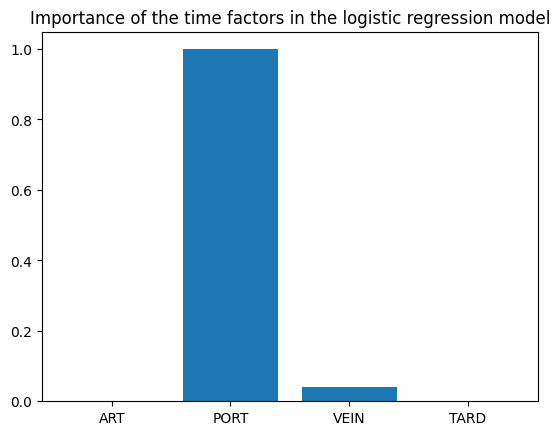

In [65]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

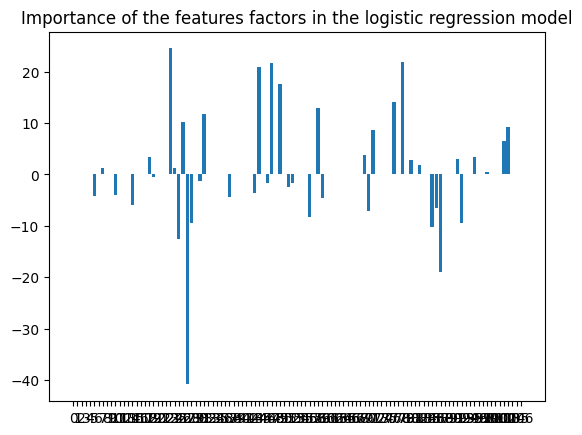

In [66]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

In [67]:
print("Selected Features : ")
for i in range(len(w_J)):
    if w_J[i] != 0:
        print(dic_global[i])

Selected Features : 
original_firstorder_Kurtosis
original_firstorder_MeanAbsoluteDeviation
original_firstorder_Minimum
original_firstorder_Skewness
original_firstorder_Uniformity
original_shape_Elongation
original_shape_Flatness
original_shape_Maximum2DDiameterRow
original_shape_Maximum2DDiameterSlice
original_shape_Maximum3DDiameter
original_shape_MeshVolume
original_shape_MinorAxisLength
original_shape_Sphericity
original_shape_SurfaceVolumeRatio
original_shape_VoxelVolume
original_glcm_Correlation
original_glcm_Idmn
original_glcm_Idn
original_glcm_Imc2
original_glcm_InverseVariance
original_glcm_JointEnergy
original_glcm_MCC
original_glcm_MaximumProbability
original_gldm_DependenceEntropy
original_gldm_DependenceNonUniformityNormalized
original_gldm_DependenceVariance
original_gldm_SmallDependenceLowGrayLevelEmphasis
original_glrlm_GrayLevelNonUniformity
original_glrlm_GrayLevelNonUniformityNormalized
original_glrlm_LongRunLowGrayLevelEmphasis
original_glrlm_RunEntropy
original_glr

#### Median slice of the 4D-tensor ####

##### CHC vs CCK  #####

In [68]:
X_med = tensor_slice[:, 2:, 1, :]
y_med = tensor_slice[:, 0, 0, 0]
y_med
X_med.shape

(114, 93, 4)

L2 penalty

In [69]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y_med == "CCK"))[0]
mask_chc = np.where(y_med == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_med[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_med[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_med[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_med[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l2", 1e-10, 1e-2, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  2.9373740229761033e-16
Number of iterations :  23
Best threshold found :  0.33366666666666667
Best score found :  0.8178571428571428
Accuracy :  0.8604651162790697
Balanced accuracy :  0.7696428571428571
Sensitivity :  0.625
Specificity :  0.9142857142857143
F1 score :  0.7424593967517402


FOLD 2
Norm between the last two steps :  6.494731770024313e-13
Number of iterations :  61
Best threshold found :  0.2026161616161616
Best score found :  0.7517857142857143
Accuracy :  0.627906976744186
Balanced accuracy :  0.675
Sensitivity :  0.75
Specificity :  0.6
F1 score :  0.6666666666666665


In [70]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.7441860465116279
+/-
0.11627906976744184
Mean balanced accuracy :  0.7223214285714286
+/-
0.047321428571428514
Mean sensitivity :  0.6875
+/-
0.0625
Mean specificity :  0.6875
+/-
0.0625
Mean f1 score :  0.7045630317092033
+/-
0.03789636504253685


(None, None, None)

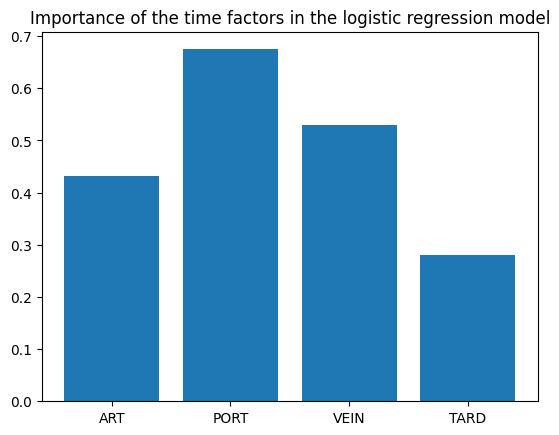

In [71]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

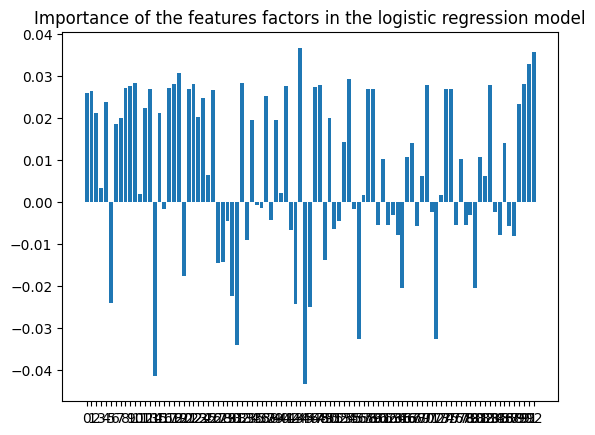

In [72]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

L1 penalty

In [73]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y_med == "CCK"))[0]
mask_chc = np.where(y_med == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_med[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_med[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_med[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_med[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l1", 1e-10, 1e1, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  0.0
Number of iterations :  16
Best threshold found :  0.8881111111111111
Best score found :  0.9857142857142858
Accuracy :  0.6744186046511628
Balanced accuracy :  0.6071428571428572
Sensitivity :  0.5
Specificity :  0.7142857142857143
F1 score :  0.588235294117647


FOLD 2
Norm between the last two steps :  1.0230454543521483e-14
Number of iterations :  38
Best threshold found :  0.8981919191919192
Best score found :  1.0
Accuracy :  0.7209302325581395
Balanced accuracy :  0.6357142857142857
Sensitivity :  0.5
Specificity :  0.7714285714285715
F1 score :  0.6067415730337079


In [74]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.6976744186046511
+/-
0.023255813953488358
Mean balanced accuracy :  0.6214285714285714
+/-
0.014285714285714235
Mean sensitivity :  0.5
+/-
0.0
Mean specificity :  0.5
+/-
0.0
Mean f1 score :  0.5974884335756774
+/-
0.009253139458030468


(None, None, None)

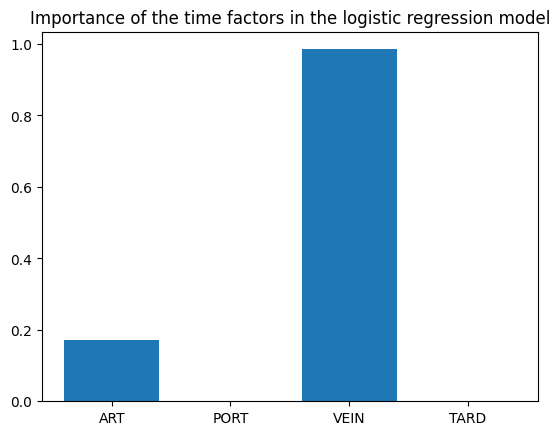

In [75]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

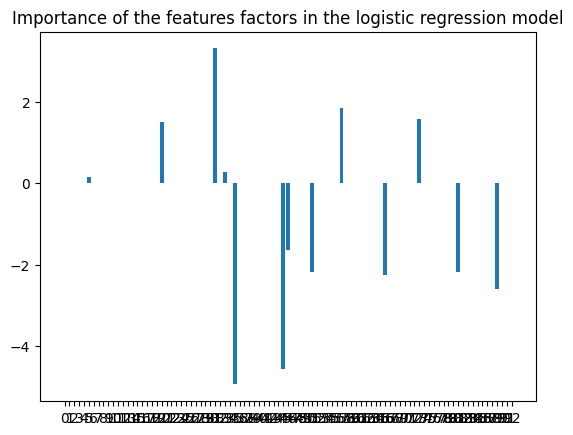

In [76]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

In [77]:
print("Selected Features : ")
for i in range(len(w_J)):
    if w_J[i] != 0:
        print(dic_slice[i])

Selected Features : 
original_firstorder_Kurtosis
original_glcm_ClusterShade
original_glcm_Imc1
original_glcm_InverseVariance
original_glcm_JointEnergy
original_gldm_DependenceVariance
original_gldm_GrayLevelNonUniformity
original_gldm_LargeDependenceLowGrayLevelEmphasis
original_glrlm_GrayLevelNonUniformityNormalized
original_glrlm_RunLengthNonUniformityNormalized
original_glszm_GrayLevelNonUniformityNormalized
original_glszm_SizeZoneNonUniformityNormalized
original_ngtdm_Coarseness


##### CHC vs Mixtes #####

L2 penalty

In [78]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where(y_med == "Mixtes")[0]
mask_chc = np.where(y_med == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_med[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_med[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_med[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_med[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l2", 1e-10, 1e1, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  6.542295141600615e-06
Number of iterations :  1000
Best threshold found :  0.7570606060606061
Best score found :  0.9807692307692308
Accuracy :  0.72
Balanced accuracy :  0.6746031746031746
Sensitivity :  0.5714285714285714
Specificity :  0.7777777777777778
F1 score :  0.6588235294117646


FOLD 2
Norm between the last two steps :  6.253890674184021e-05
Number of iterations :  1000
Best threshold found :  0.44455555555555554
Best score found :  0.9331501831501832
Accuracy :  0.68
Balanced accuracy :  0.6468253968253967
Sensitivity :  0.5714285714285714
Specificity :  0.7222222222222222
F1 score :  0.638036809815951


FOLD 3
Norm between the last two steps :  3.9608688043348254e-12
Number of iterations :  193
Best threshold found :  0.5655252525252525
Best score found :  0.9335130278526504
Accuracy :  0.75
Balanced accuracy :  0.7815126050420168
Sensitivity :  0.8571428571428571
Specificity :  0.7058823529411765
F1 score :  0.7741935483870968



In [79]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.7041666666666666
+/-
0.032945662334617994
Mean balanced accuracy :  0.6853991596638656
+/-
0.05706850293597917
Mean sensitivity :  0.6428571428571428
+/-
0.12371791482634838
Mean specificity :  0.6428571428571428
+/-
0.12371791482634838
Mean f1 score :  0.6756582087458084
+/-
0.05777319994495639


(None, None, None)

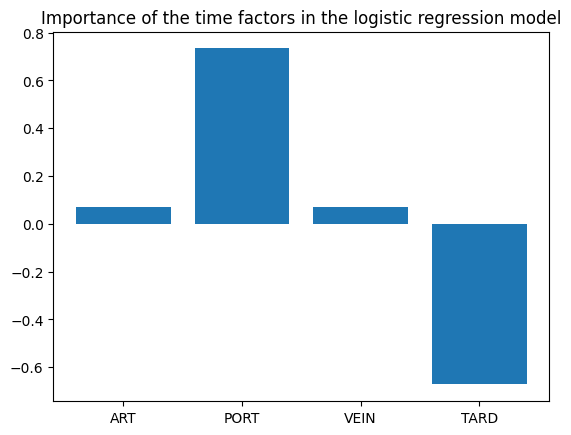

In [80]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

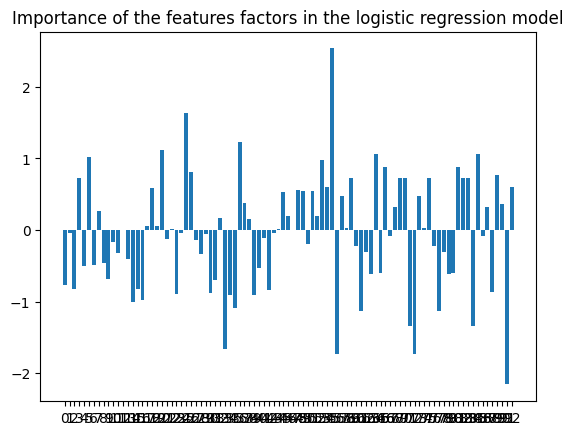

In [81]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

L1 penalty

In [82]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where(y_med == "Mixtes")[0]
mask_chc = np.where(y_med == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_med[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_med[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_med[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_med[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l1", 1e-10, 1e0, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  1.440062861124582e-13
Number of iterations :  49
Best threshold found :  0.4042323232323232
Best score found :  0.7898351648351649
Accuracy :  0.76
Balanced accuracy :  0.7023809523809523
Sensitivity :  0.5714285714285714
Specificity :  0.8333333333333334
F1 score :  0.6779661016949152


FOLD 2
Norm between the last two steps :  2.3244335749825554e-12
Number of iterations :  77
Best threshold found :  0.4546363636363636
Best score found :  0.8237179487179487
Accuracy :  0.68
Balanced accuracy :  0.5595238095238095
Sensitivity :  0.2857142857142857
Specificity :  0.8333333333333334
F1 score :  0.42553191489361697


FOLD 3
Norm between the last two steps :  8.333377582632083e-15
Number of iterations :  38
Best threshold found :  0.34374747474747475
Best score found :  0.7578616352201257
Accuracy :  0.5833333333333334
Balanced accuracy :  0.4957983193277311
Sensitivity :  0.2857142857142857
Specificity :  0.7058823529411765
F1 score :  0.4067796

In [83]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.6516666666666667
+/-
0.07395569244111262
Mean balanced accuracy :  0.5948879551820728
+/-
0.07640518154793963
Mean sensitivity :  0.4642857142857143
+/-
0.18557687223952257
Mean specificity :  0.4642857142857143
+/-
0.18557687223952257
Mean f1 score :  0.5295964464283973
+/-
0.11628738659670891


(None, None, None)

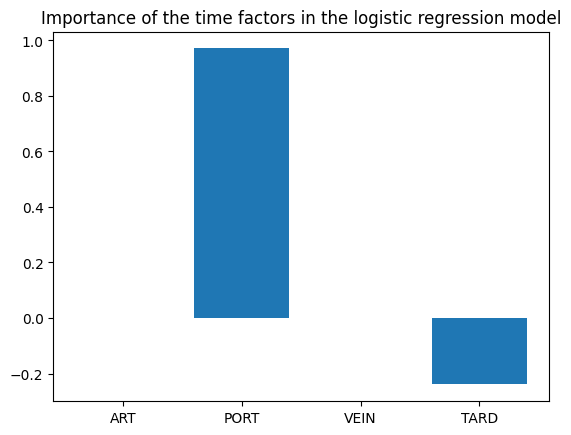

In [84]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

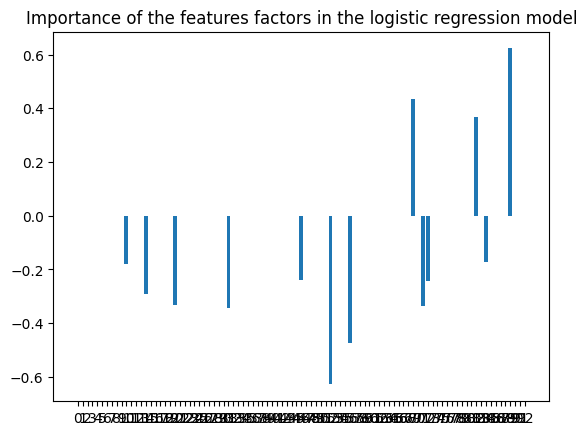

In [85]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

In [86]:
print("Selected Features : ")
for i in range(len(w_J)):
    if w_J[i] != 0:
        print(dic_slice[i])

Selected Features : 
original_firstorder_Minimum
original_firstorder_Skewness
original_glcm_ClusterShade
original_glcm_Imc1
original_gldm_GrayLevelNonUniformity
original_gldm_LowGrayLevelEmphasis
original_glrlm_GrayLevelNonUniformity
original_glrlm_ShortRunEmphasis
original_glrlm_ShortRunLowGrayLevelEmphasis
original_glszm_GrayLevelNonUniformity
original_glszm_SmallAreaEmphasis
original_glszm_SmallAreaLowGrayLevelEmphasis
original_ngtdm_Coarseness


##### CHC vs Others ######

L2 penalty

In [87]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y_med == "Mixtes") | (y_med == "CCK"))[0]
mask_chc = np.where(y_med == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_med[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_med[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_med[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_med[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l2", 1e-10, 1e-2, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  3.885780586188048e-16
Number of iterations :  30
Best threshold found :  0.43447474747474746
Best score found :  0.7715617715617715
Accuracy :  0.6551724137931034
Balanced accuracy :  0.6338383838383839
Sensitivity :  0.5454545454545454
Specificity :  0.7222222222222222
F1 score :  0.6215139442231075


FOLD 2
Norm between the last two steps :  4.335559509131367e-16
Number of iterations :  24
Best threshold found :  0.3538282828282828
Best score found :  0.7497086247086246
Accuracy :  0.5862068965517241
Balanced accuracy :  0.595959595959596
Sensitivity :  0.6363636363636364
Specificity :  0.5555555555555556
F1 score :  0.5932203389830508


FOLD 3
Norm between the last two steps :  2.9862690607732124e-14
Number of iterations :  38
Best threshold found :  0.4848787878787879
Best score found :  0.7161234991423671
Accuracy :  0.8214285714285714
Balanced accuracy :  0.7727272727272727
Sensitivity :  0.5454545454545454
Specificity :  1.0
F1 score :

In [88]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.667487684729064
+/-
0.09232757881477685
Mean balanced accuracy :  0.645684789067142
+/-
0.07589328301313447
Mean sensitivity :  0.5454545454545454
+/-
0.0642824346533225
Mean specificity :  0.5454545454545454
+/-
0.0642824346533225
Mean f1 score :  0.618403006963101
+/-
0.05606834401809027


(None, None, None)

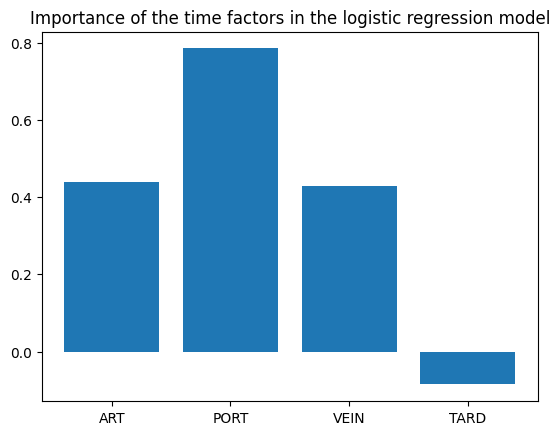

In [89]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

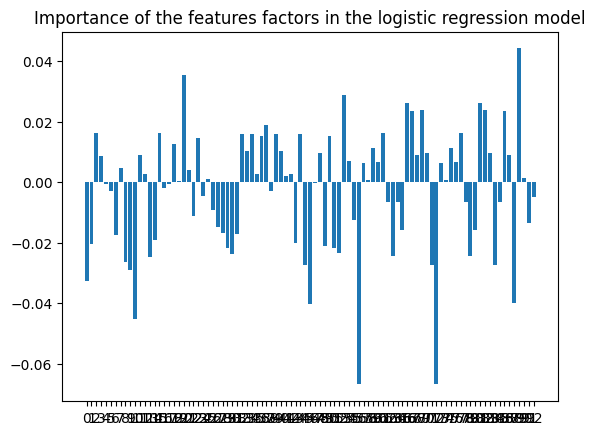

In [90]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

L1 penalty

In [91]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y_med == "Mixtes") | (y_med == "CCK"))[0]
mask_chc = np.where(y_med == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_med[train_indices, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_med[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_med[test_indices, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_med[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression(X_tr, y_tr, "l1", 1e-10, 1e1, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)

    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  0.0001228417834221852
Number of iterations :  1000
Best threshold found :  0.6864949494949495
Best score found :  0.9105477855477855
Accuracy :  0.6206896551724138
Balanced accuracy :  0.606060606060606
Sensitivity :  0.5454545454545454
Specificity :  0.6666666666666666
F1 score :  0.6


FOLD 2
Norm between the last two steps :  6.012307471672395e-05
Number of iterations :  1000
Best threshold found :  0.3235858585858586
Best score found :  0.9230769230769231
Accuracy :  0.3793103448275862
Balanced accuracy :  0.35858585858585856
Sensitivity :  0.2727272727272727
Specificity :  0.4444444444444444
F1 score :  0.3380281690140845


FOLD 3
Norm between the last two steps :  0.0
Number of iterations :  14
Best threshold found :  0.6562525252525253
Best score found :  0.8619210977701544
Accuracy :  0.7142857142857143
Balanced accuracy :  0.6844919786096256
Sensitivity :  0.5454545454545454
Specificity :  0.8235294117647058
F1 score :  0.65625


FOL

In [92]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.5446428571428572
+/-
0.13072291737371694
Mean balanced accuracy :  0.527926322043969
+/-
0.12606131937353132
Mean sensitivity :  0.45454545454545453
+/-
0.11134044285378081
Mean specificity :  0.45454545454545453
+/-
0.11134044285378081
Mean f1 score :  0.5141764786697062
+/-
0.1237504753918878


(None, None, None)

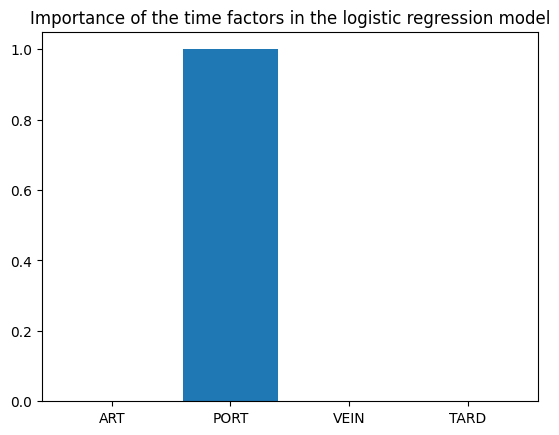

In [93]:
w_0, w_K, w_J = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

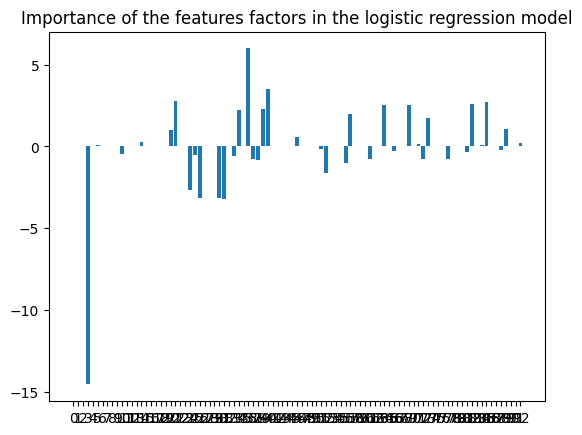

In [94]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

In [95]:
print("Selected Features : ")
for i in range(len(w_J)):
    if w_J[i] != 0:
        print(dic_slice[i])

Selected Features : 
original_firstorder_Entropy
original_firstorder_Kurtosis
original_firstorder_Minimum
original_firstorder_Skewness
original_glcm_ClusterShade
original_glcm_ClusterTendency
original_glcm_DifferenceAverage
original_glcm_DifferenceEntropy
original_glcm_DifferenceVariance
original_glcm_Idn
original_glcm_Imc1
original_glcm_InverseVariance
original_glcm_JointAverage
original_glcm_JointEntropy
original_glcm_MCC
original_glcm_MaximumProbability
original_glcm_SumAverage
original_glcm_SumEntropy
original_gldm_GrayLevelNonUniformity
original_gldm_LargeDependenceLowGrayLevelEmphasis
original_gldm_LowGrayLevelEmphasis
original_glrlm_GrayLevelNonUniformity
original_glrlm_GrayLevelNonUniformityNormalized
original_glrlm_LongRunHighGrayLevelEmphasis
original_glrlm_RunEntropy
original_glrlm_RunLengthNonUniformityNormalized
original_glrlm_ShortRunEmphasis
original_glrlm_ShortRunLowGrayLevelEmphasis
original_glszm_GrayLevelNonUniformity
original_glszm_GrayLevelNonUniformityNormalized
o

#### Slice tensor (4D) ####

In [96]:
tensor_slice.shape

(114, 95, 3, 4)

Almost the same code a before but with a new coefficient vector to estimate (the space factor).

In [97]:
from sklearn.linear_model import LogisticRegression


class MultiwayLogisticRegression4D:
    def __init__(self, X, y, penalty, tol=1e-4, lambda_0=0.01, max_iter=250):
        self.X = X
        self.y = y
        self.tol = tol
        self.lambda_0 = lambda_0
        self.max_iter = max_iter
        self.I, self.J, self.L, self.K = X.shape
        self.N = self.I
        self.w_0 = None
        self.w_K = None
        self.w_J = None
        self.penalty = penalty

    def get_features(self):
        return self.X

    def get_labels(self):
        return self.y

    def get_dimensions(self):
        return X.shape

    def get_weights(self):
        return self.w_0, self.w_K, self.w_J, self.w_L

    def logistic_reg(self, X, y, lambda_reg):
        clf = LogisticRegression(
            random_state=0,
            fit_intercept=True,
            penalty=self.penalty,
            solver="liblinear",
            C=1 / lambda_reg * self.lambda_0,
        ).fit(X, y)
        return clf.intercept_, clf.coef_[0]

    def fit(self):
        self.w_K = np.random.normal(1, 1 / self.K, self.K)
        self.w_K /= np.linalg.norm(self.w_K, ord=2)

        self.w_L = np.random.normal(1, 1 / self.L, self.L)
        self.w_L /= np.linalg.norm(self.w_L, ord=2)

        has_converged = False
        q = 0
        does_not_move_since = 0
        while not has_converged and q < self.max_iter:
            w_K_old = self.w_K
            w_L_old = self.w_L

            x_iJ = np.zeros((self.N, self.J))
            for k in range(self.K):
                for l in range(self.L):
                    for i in range(self.N):
                        x_iJ[i, :] += self.X[i, :, l, k] * self.w_K[k] * self.w_L[l]
            assert x_iJ.shape == (self.N, self.J)
            self.w_0, self.w_J = self.logistic_reg(
                x_iJ, self.y, np.linalg.norm(self.w_K, ord=2) ** 2
            )

            x_iK = np.zeros((self.N, self.K))
            for j in range(self.J):
                for l in range(self.L):
                    for i in range(self.N):
                        x_iK[i, :] += self.X[i, j, l, :] * self.w_J[j] * self.w_L[l]
            assert x_iK.shape == (self.N, self.K)

            self.w_0, self.w_K = self.logistic_reg(
                x_iK, self.y, np.linalg.norm(self.w_J, ord=2) ** 2
            )
            self.w_K /= np.linalg.norm(self.w_K, ord=2)

            x_iL = np.zeros((self.N, self.L))
            for j in range(self.J):
                for k in range(self.K):
                    for i in range(self.N):
                        x_iL[i, :] += self.X[i, j, :, k] * self.w_J[j] * self.w_K[k]
            assert x_iL.shape == (self.N, self.L)

            self.w_0, self.w_L = self.logistic_reg(
                x_iL, self.y, np.linalg.norm(self.w_J, ord=2) ** 2
            )
            self.w_L /= np.linalg.norm(self.w_L, ord=2)

            q += 1
            if np.linalg.norm(self.w_K - w_K_old, ord=2) < self.tol:
                if does_not_move_since > 10:
                    has_converged = True
                else:
                    does_not_move_since += 1
            else:
                does_not_move_since = 0

        print(
            "Norm between the last two steps : ",
            np.linalg.norm(self.w_K - w_K_old, ord=2),
        )
        print("Number of iterations : ", q)
        return self.w_0, self.w_K, self.w_J, self.w_L

    def predict_proba(self, X_test, w_0, w_K, w_J, w_L):
        exponent = (
            w_0
            + np.kron(w_J, np.kron(w_L, w_K)).T
            @ X_test.reshape((X_test.shape[0], self.J * self.K * self.L)).T
        )
        proba = np.exp(exponent) / (1 + np.exp(exponent))
        return proba

    def fit_predict(self, X_test):
        w_0, w_K, w_J, w_L = self.fit()
        threshold = self.find_threshold(w_0, w_K, w_J, w_L)
        proba = self.predict_proba(X_test, w_0, w_K, w_J, w_L)
        return proba > threshold

    def predict(self, X_test, w_0, w_K, w_J, w_L, threshold=0.5):
        proba = self.predict_proba(X_test, w_0, w_K, w_J, w_L)
        return proba > threshold

    def find_threshold(self, w_0, w_K, w_J, w_L):
        best_threshold = 0
        best_score = 0
        for threshold in np.linspace(0.001, 1 - 0.001, 100):
            y_pred = self.predict(self.X, w_0, w_K, w_J, w_L, threshold)
            tp = np.sum(np.logical_and(y_pred == True, self.y == True))
            tn = np.sum(np.logical_and(y_pred == False, self.y == False))
            fp = np.sum(np.logical_and(y_pred == True, self.y == False))
            fn = np.sum(np.logical_and(y_pred == False, self.y == True))
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
            f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)
            score = balanced_accuracy
            if score > best_score:
                best_score = score
                best_threshold = threshold

        print("Best threshold found : ", best_threshold)
        print("Best score found : ", best_score)
        return best_threshold

    def area_under_curve(self, X_test, y_test):
        tpr_list = []
        fpr_list = []
        w_0, w_K, w_J, w_L = self.fit()
        proba = self.predict_proba(X_test, w_0, w_K, w_J, w_L)
        for threshold in np.linspace(0, 1, 100):
            y_pred = self.predict(X_test, w_0, w_K, w_J, w_L, threshold)
            tp = np.sum(np.logical_and(y_pred == True, y_test == True))
            tn = np.sum(np.logical_and(y_pred == False, y_test == False))
            fp = np.sum(np.logical_and(y_pred == True, y_test == False))
            fn = np.sum(np.logical_and(y_pred == False, y_test == True))
            tpr = tp / (tp + fn)
            fpr = fp / (fp + tn)
            tpr_list.append(tpr)
            fpr_list.append(fpr)
        plt.plot(fpr_list, tpr_list)
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title("ROC curve")
        plt.show()

In [98]:
X_slice = tensor_slice[:, 2:, :, :]
y_slice = tensor_slice[:, 0, 0, 0]
y_slice
X_slice.shape

(114, 93, 3, 4)

##### CHC vs CCK #####

L2 penalty

In [99]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y_slice == "CCK"))[0]
mask_chc = np.where(y_slice == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_slice[train_indices, :, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_slice[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_slice[test_indices, :, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_slice[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression4D(X_tr, y_tr, "l2", 1e-10, 1e-3, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)
    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  4.1910000110727263e-16
Number of iterations :  23
Best threshold found :  0.28326262626262627
Best score found :  0.775
Accuracy :  0.8372093023255814
Balanced accuracy :  0.7553571428571428
Sensitivity :  0.625
Specificity :  0.8857142857142857
F1 score :  0.7328605200945627


FOLD 2
Norm between the last two steps :  6.106226635438361e-16
Number of iterations :  29
Best threshold found :  0.24293939393939395
Best score found :  0.7553571428571428
Accuracy :  0.7674418604651163
Balanced accuracy :  0.7607142857142857
Sensitivity :  0.75
Specificity :  0.7714285714285715
F1 score :  0.7605633802816902


In [100]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.8023255813953489
+/-
0.034883720930232565
Mean balanced accuracy :  0.7580357142857143
+/-
0.002678571428571419
Mean sensitivity :  0.6875
+/-
0.0625
Mean specificity :  0.6875
+/-
0.0625
Mean f1 score :  0.7467119501881265
+/-
0.013851430093563766


(None, None, None)

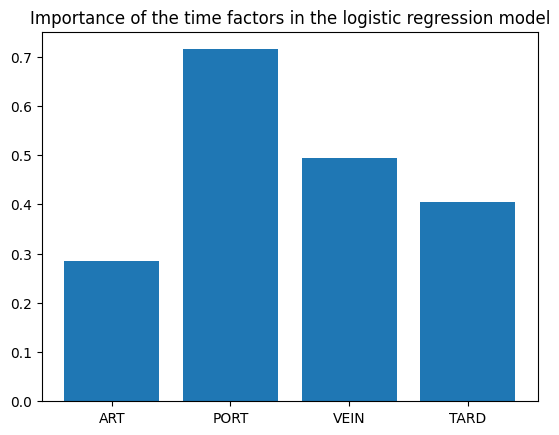

In [101]:
w_0, w_K, w_J, w_L = best_clf.get_weights()
plt.bar(np.arange(len(w_K)), w_K)
plt.title("Importance of the time factors in the logistic regression model")
plt.xticks(np.arange(len(w_K)), ["ART", "PORT", "VEIN", "TARD"])
plt.show()

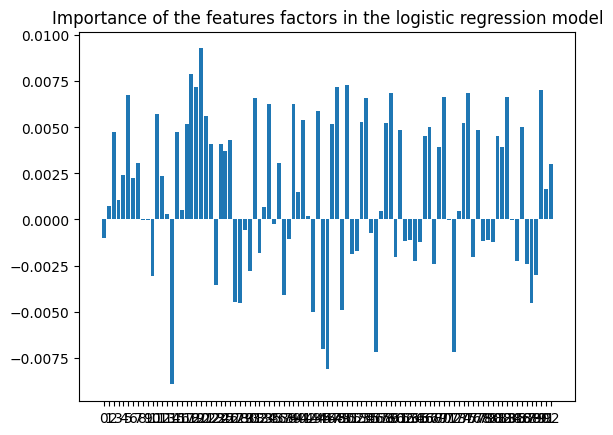

In [102]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

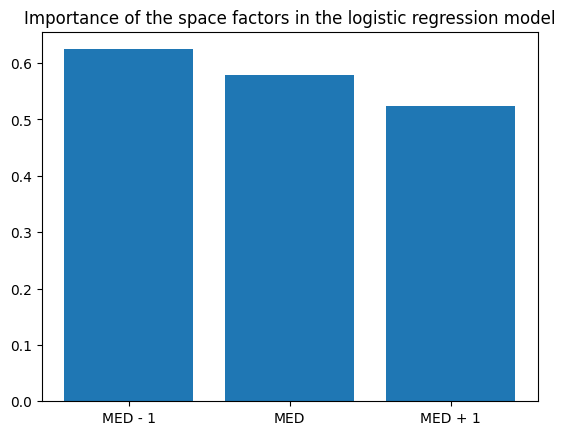

In [103]:
plt.bar(np.arange(len(w_L)), w_L)
plt.title("Importance of the space factors in the logistic regression model")
plt.xticks(np.arange(len(w_L)), ["MED - 1", "MED", "MED + 1"])
plt.show()

Here we can see that the space factor does not have a lot of interest as each slice seems to have a similar impact on the prediction.

L1 penalty

In [104]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y_slice == "CCK"))[0]
mask_chc = np.where(y_slice == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_slice[train_indices, :, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_slice[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_slice[test_indices, :, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_slice[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression4D(X_tr, y_tr, "l1", 1e-10, 0.5, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)
    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  1.2412670766236366e-15
Number of iterations :  35
Best threshold found :  0.25302020202020203
Best score found :  0.9089285714285714
Accuracy :  0.6744186046511628
Balanced accuracy :  0.6553571428571429
Sensitivity :  0.625
Specificity :  0.6857142857142857
F1 score :  0.6539509536784741


FOLD 2
Norm between the last two steps :  3.8518327042913085e-12
Number of iterations :  84
Best threshold found :  0.1622929292929293
Best score found :  0.9428571428571428
Accuracy :  0.5813953488372093
Balanced accuracy :  0.55
Sensitivity :  0.5
Specificity :  0.6
F1 score :  0.5454545454545454


In [105]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.627906976744186
+/-
0.046511627906976716
Mean balanced accuracy :  0.6026785714285714
+/-
0.05267857142857141
Mean sensitivity :  0.5625
+/-
0.0625
Mean specificity :  0.5625
+/-
0.0625
Mean f1 score :  0.5997027495665097
+/-
0.05424820411196435


(None, None, None)

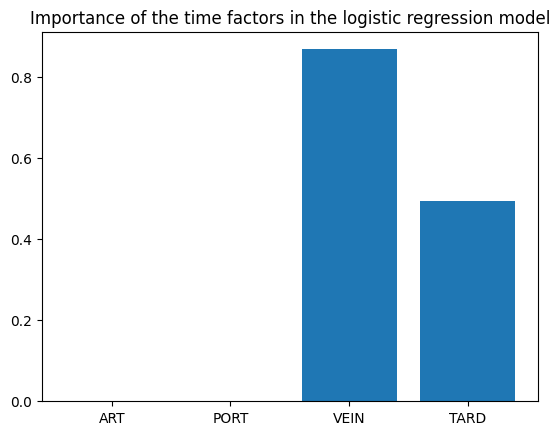

In [106]:
w_0, w_K, w_J, w_L = best_clf.get_weights()
plt.bar(np.arange(len(w_K)),w_K)
plt.title('Importance of the time factors in the logistic regression model')
plt.xticks(np.arange(len(w_K)),['ART','PORT','VEIN','TARD'])
plt.show()

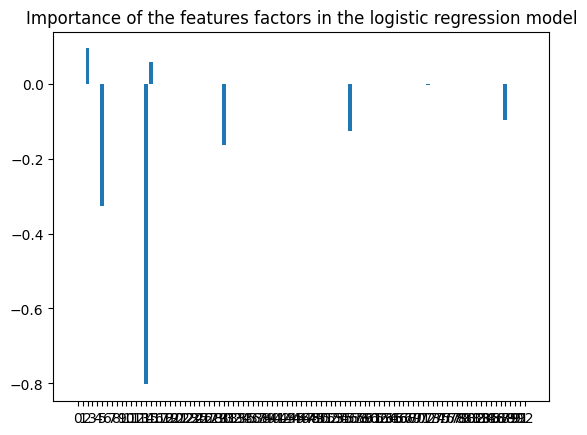

In [107]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

In [108]:
print("Selected Features : ")
for i in range(len(w_J)):
    if w_J[i] != 0:
        print(dic_slice[i])

Selected Features : 
original_firstorder_Energy
original_firstorder_Kurtosis
original_firstorder_Skewness
original_firstorder_TotalEnergy
original_glcm_Idn
original_glrlm_GrayLevelNonUniformity
original_glszm_GrayLevelNonUniformity
original_ngtdm_Busyness


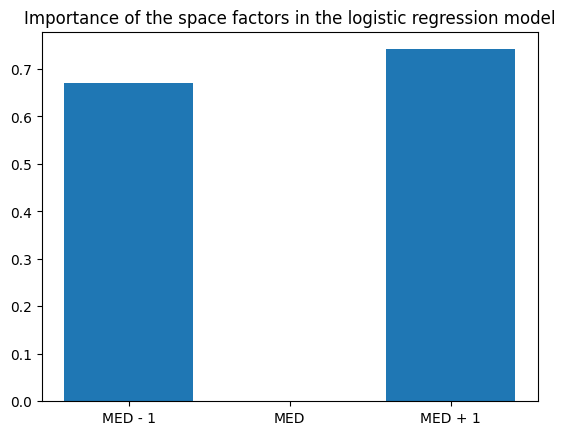

In [109]:
plt.bar(np.arange(len(w_L)), w_L)
plt.title("Importance of the space factors in the logistic regression model")
plt.xticks(np.arange(len(w_L)), ["MED - 1", "MED", "MED + 1"])
plt.show()

##### CHC vs Mixtes #####

L2 penalty

In [110]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y_slice == "Mixtes"))[0]
mask_chc = np.where(y_slice == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_slice[train_indices, :, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_slice[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_slice[test_indices, :, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_slice[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression4D(X_tr, y_tr, "l2", 1e-10, 1e-1, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)
    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  5.4310632089168856e-11
Number of iterations :  354
Best threshold found :  0.38407070707070706
Best score found :  0.8420329670329669
Accuracy :  0.8
Balanced accuracy :  0.7738095238095238
Sensitivity :  0.7142857142857143
Specificity :  0.8333333333333334
F1 score :  0.7692307692307692


FOLD 2
Norm between the last two steps :  8.426669976292489e-12
Number of iterations :  104
Best threshold found :  0.29334343434343435
Best score found :  0.8516483516483516
Accuracy :  0.72
Balanced accuracy :  0.6746031746031746
Sensitivity :  0.5714285714285714
Specificity :  0.7777777777777778
F1 score :  0.6588235294117646


FOLD 3
Norm between the last two steps :  1.0221992739194867e-11
Number of iterations :  106
Best threshold found :  0.4143131313131313
Best score found :  0.8337825696316262
Accuracy :  0.625
Balanced accuracy :  0.6092436974789917
Sensitivity :  0.5714285714285714
Specificity :  0.6470588235294118
F1 score :  0.6068965517241379


In [111]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.63
+/-
0.1597263284496329
Mean balanced accuracy :  0.5910947712418302
+/-
0.1743238357747847
Mean sensitivity :  0.49999999999999994
+/-
0.2142857142857143
Mean specificity :  0.49999999999999994
+/-
0.2142857142857143
Mean f1 score :  0.5635322331396131
+/-
0.20727551971746097


(None, None, None)

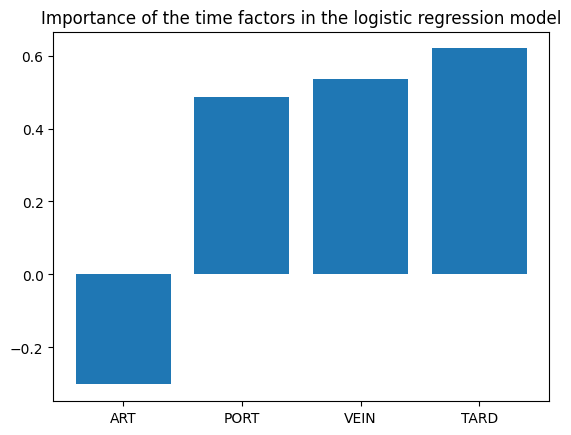

In [112]:
w_0, w_K, w_J, w_L = best_clf.get_weights()
plt.bar(np.arange(len(w_K)),w_K)
plt.title('Importance of the time factors in the logistic regression model')
plt.xticks(np.arange(len(w_K)),['ART','PORT','VEIN','TARD'])
plt.show()

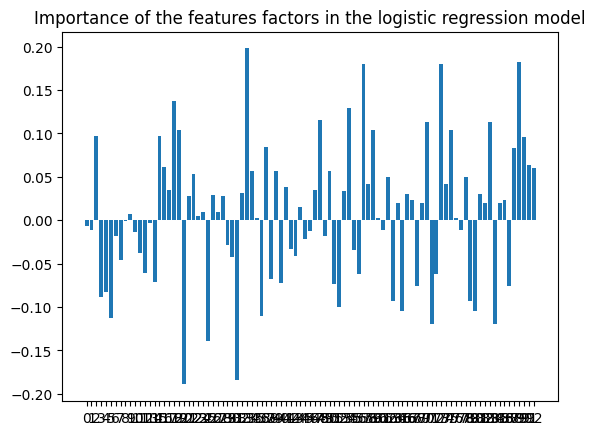

In [113]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

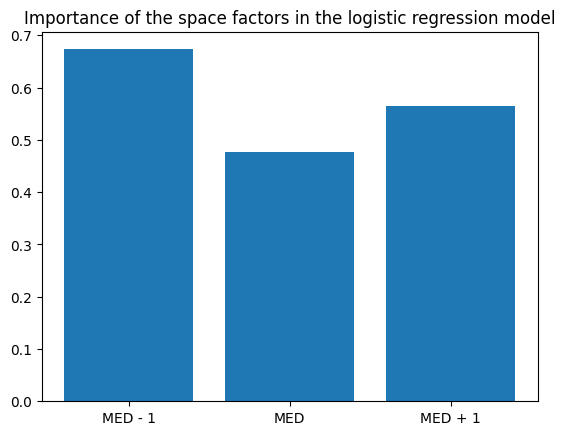

In [114]:
plt.bar(np.arange(len(w_L)), w_L)
plt.title("Importance of the space factors in the logistic regression model")
plt.xticks(np.arange(len(w_L)), ["MED - 1", "MED", "MED + 1"])
plt.show()

L1 penalty

In [115]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y_slice == "Mixtes"))[0]
mask_chc = np.where(y_slice == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_slice[train_indices, :, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_slice[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_slice[test_indices, :, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_slice[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression4D(X_tr, y_tr, "l1", 1e-10, 1e0, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)
    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  1.4529788014664682e-13
Number of iterations :  63
Best threshold found :  0.39415151515151514
Best score found :  0.7898351648351649
Accuracy :  0.76
Balanced accuracy :  0.7023809523809523
Sensitivity :  0.5714285714285714
Specificity :  0.8333333333333334
F1 score :  0.6779661016949152


FOLD 2
Norm between the last two steps :  0.0
Number of iterations :  16
Best threshold found :  0.5655252525252525
Best score found :  0.8855311355311355
Accuracy :  0.72
Balanced accuracy :  0.6746031746031746
Sensitivity :  0.5714285714285714
Specificity :  0.7777777777777778
F1 score :  0.6588235294117646


FOLD 3
Norm between the last two steps :  2.355040964097765e-14
Number of iterations :  60
Best threshold found :  0.4243939393939394
Best score found :  0.8814016172506738
Accuracy :  0.6666666666666666
Balanced accuracy :  0.5966386554621849
Sensitivity :  0.42857142857142855
Specificity :  0.7647058823529411
F1 score :  0.5492957746478873


FOLD 4

In [116]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.7241666666666666
+/-
0.036314597615834894
Mean balanced accuracy :  0.6782796451914099
+/-
0.05245726368192246
Mean sensitivity :  0.5714285714285714
+/-
0.10101525445522108
Mean specificity :  0.5714285714285714
+/-
0.10101525445522108
Mean f1 score :  0.6561804423477327
+/-
0.06838295110494062


(None, None, None)

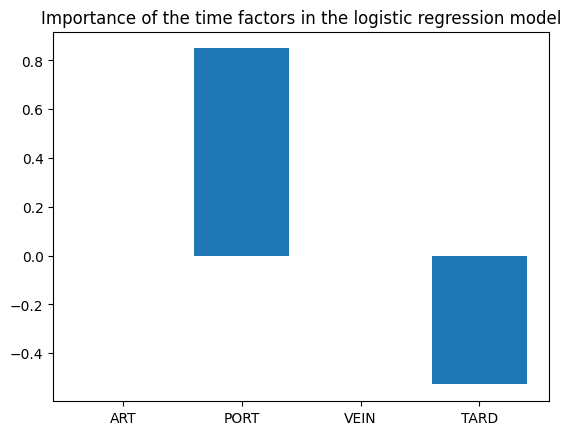

In [117]:
w_0, w_K, w_J, w_L = best_clf.get_weights()
plt.bar(np.arange(len(w_K)),w_K)
plt.title('Importance of the time factors in the logistic regression model')
plt.xticks(np.arange(len(w_K)),['ART','PORT','VEIN','TARD'])
plt.show()

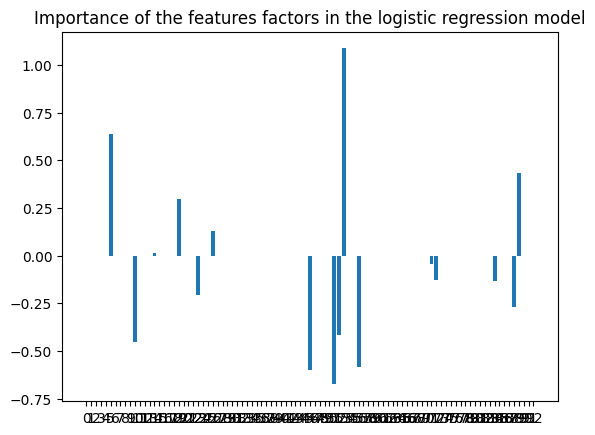

In [118]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

In [119]:
print("Selected Features : ")
for i in range(len(w_J)):
    if w_J[i] != 0:
        print(dic_slice[i])

Selected Features : 
original_firstorder_Kurtosis
original_firstorder_Minimum
original_firstorder_Skewness
original_glcm_ClusterProminence
original_glcm_Correlation
original_glcm_DifferenceVariance
original_gldm_GrayLevelNonUniformity
original_gldm_LargeDependenceLowGrayLevelEmphasis
original_gldm_LowGrayLevelEmphasis
original_gldm_SmallDependenceEmphasis
original_glrlm_GrayLevelNonUniformity
original_glrlm_ShortRunLowGrayLevelEmphasis
original_glszm_GrayLevelNonUniformity
original_glszm_SmallAreaLowGrayLevelEmphasis
original_ngtdm_Busyness
original_ngtdm_Coarseness


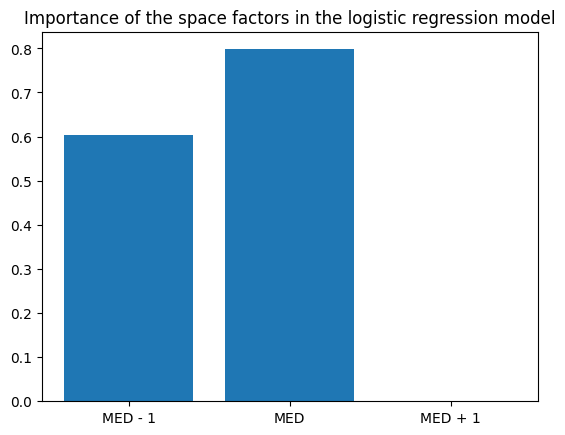

In [120]:
plt.bar(np.arange(len(w_L)), w_L)
plt.title("Importance of the space factors in the logistic regression model")
plt.xticks(np.arange(len(w_L)), ["MED - 1", "MED", "MED + 1"])
plt.show()

##### CHC vs Others ######

L2 penalty

In [121]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y_slice == "Mixtes")|(y_slice =='CCK'))[0]
mask_chc = np.where(y_slice == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_slice[train_indices, :, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_slice[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_slice[test_indices, :, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_slice[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression4D(X_tr, y_tr, "l2", 1e-10, 1e-2, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)
    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  4.710277376051325e-16
Number of iterations :  32
Best threshold found :  0.4848787878787879
Best score found :  0.7645687645687647
Accuracy :  0.6896551724137931
Balanced accuracy :  0.6262626262626263
Sensitivity :  0.36363636363636365
Specificity :  0.8888888888888888
F1 score :  0.5161290322580644


FOLD 2
Norm between the last two steps :  1.7554167342883506e-16
Number of iterations :  28
Best threshold found :  0.4143131313131313
Best score found :  0.7770979020979021
Accuracy :  0.4827586206896552
Balanced accuracy :  0.44191919191919193
Sensitivity :  0.2727272727272727
Specificity :  0.6111111111111112
F1 score :  0.3771428571428571


FOLD 3
Norm between the last two steps :  1.4811033652577087e-13
Number of iterations :  48
Best threshold found :  0.5151212121212121
Best score found :  0.7501429388221841
Accuracy :  0.7857142857142857
Balanced accuracy :  0.7433155080213903
Sensitivity :  0.5454545454545454
Specificity :  0.941176470

In [122]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.6502463054187192
+/-
0.10955746978465133
Mean balanced accuracy :  0.6133021390374331
+/-
0.10868606321981658
Mean sensitivity :  0.4545454545454545
+/-
0.14373989364401724
Mean specificity :  0.4545454545454545
+/-
0.14373989364401724
Mean f1 score :  0.5563965095204941
+/-
0.12149862646455345


(None, None, None)

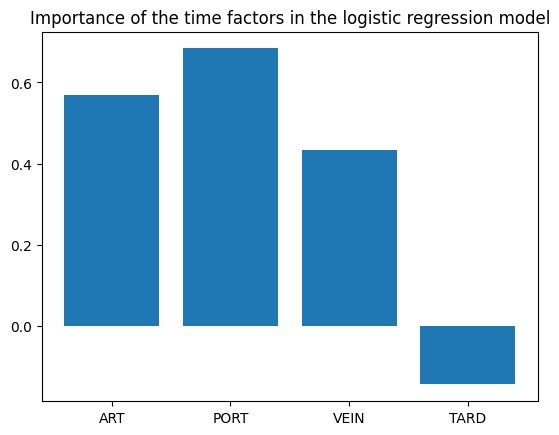

In [123]:
w_0, w_K, w_J, w_L = best_clf.get_weights()
plt.bar(np.arange(len(w_K)),w_K)
plt.title('Importance of the time factors in the logistic regression model')
plt.xticks(np.arange(len(w_K)),['ART','PORT','VEIN','TARD'])
plt.show()

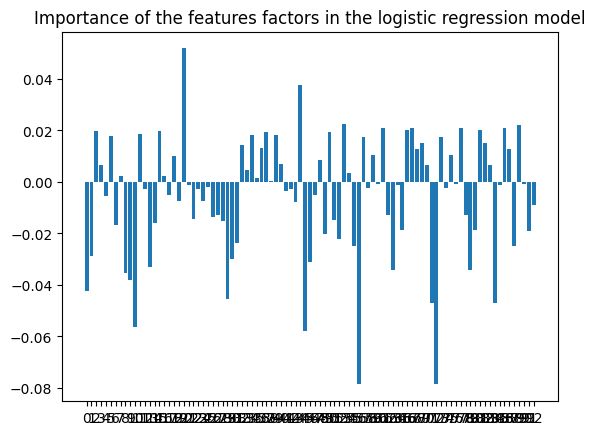

In [124]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

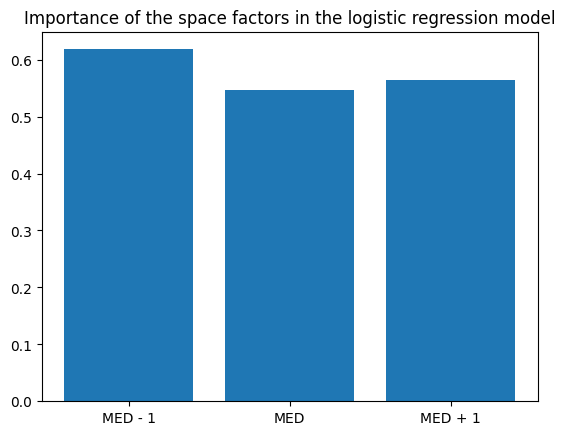

In [125]:
plt.bar(np.arange(len(w_L)), w_L)
plt.title("Importance of the space factors in the logistic regression model")
plt.xticks(np.arange(len(w_L)), ["MED - 1", "MED", "MED + 1"])
plt.show()

L1 penalty

In [126]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

acc_list = []
balanced_acc_list = []
sen_list = []
spe_list = []
f1_list = []
best_score = 0

dic_label = {"CHC": 0, "CCK": 1, "Mixtes": 1}
mask_cck = np.where((y_slice == "Mixtes")|(y_slice =='CCK'))[0]
mask_chc = np.where(y_slice == "CHC")[0]

kf.get_n_splits(mask_chc)
kf.get_n_splits(mask_cck)


for (a, b), (c, d) in zip(enumerate(kf.split(mask_chc)), enumerate(kf.split(mask_cck))):
    train_indices_chc = b[0]
    test_indices_chc = b[1]
    train_indices_cck = d[0] + len(mask_chc)
    test_indices_cck = d[1] + len(mask_chc)
    print("\n")
    print(f"FOLD {a+1}")

    train_indices = np.concatenate([train_indices_cck, train_indices_chc])
    test_indices = np.concatenate([test_indices_chc, test_indices_cck])

    X_tr = X_slice[train_indices, :, :, :]
    X_tr = (X_tr.astype(float) - np.mean(X_tr.astype(float), axis=0)) / np.std(
        X_tr.astype(float), axis=0
    )
    X_tr = X_tr.astype(float)
    y_tr = y_slice[train_indices]
    y_tr = np.array([dic_label[y] for y in y_tr])

    X_te = X_slice[test_indices, :, :, :]
    X_te = (X_te - np.mean(X_te.astype(float), axis=0)) / np.std(
        X_te.astype(float), axis=0
    )
    X_te = X_te.astype(float)
    y_te = y_slice[test_indices]
    y_te = np.array([dic_label[y] for y in y_te])

    clf = MultiwayLogisticRegression4D(X_tr, y_tr, "l1", 1e-10, 1e0, 1000)

    y_pred = clf.fit_predict(X_te)

    tp = np.sum(np.logical_and(y_pred == True, y_te == 1))
    tn = np.sum(np.logical_and(y_pred == False, y_te == 0))
    fp = np.sum(np.logical_and(y_pred == True, y_te == 0))
    fn = np.sum(np.logical_and(y_pred == False, y_te == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * specificity * sensitivity / (specificity + sensitivity)
    f2_score = 5 * specificity * sensitivity / (4 * sensitivity + specificity)
    if f1_score > best_score:
        best_score = f1_score
        best_clf = clf

    print("Accuracy : ", accuracy)
    print("Balanced accuracy : ", balanced_accuracy)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("F1 score : ", f1_score)

    acc_list.append(accuracy)
    balanced_acc_list.append(balanced_accuracy)
    sen_list.append(sensitivity)
    spe_list.append(sensitivity)
    f1_list.append(f1_score)



FOLD 1
Norm between the last two steps :  0.00285450380747243
Number of iterations :  1000
Best threshold found :  0.28326262626262627
Best score found :  0.7966200466200466
Accuracy :  0.41379310344827586
Balanced accuracy :  0.43939393939393934
Sensitivity :  0.5454545454545454
Specificity :  0.3333333333333333
F1 score :  0.41379310344827586


FOLD 2
Norm between the last two steps :  0.0005346878229744347
Number of iterations :  1000
Best threshold found :  0.4647171717171717
Best score found :  0.8487762237762237
Accuracy :  0.4827586206896552
Balanced accuracy :  0.4595959595959596
Sensitivity :  0.36363636363636365
Specificity :  0.5555555555555556
F1 score :  0.4395604395604396


FOLD 3
Norm between the last two steps :  3.0643472055366765e-05
Number of iterations :  1000
Best threshold found :  0.5050404040404041
Best score found :  0.8467695826186392
Accuracy :  0.6071428571428571
Balanced accuracy :  0.5962566844919786
Sensitivity :  0.5454545454545454
Specificity :  0.647

In [127]:
acc = np.array(acc_list)
balanced_acc = np.array(balanced_acc_list)
sen = np.array(sen_list)
spe = np.array(spe_list)
f1 = np.array(f1_list)

print("Mean accuracy : ", np.mean(acc)), print("+/-"), print(np.std(acc))
print("Mean balanced accuracy : ", np.mean(balanced_acc)), print("+/-"), print(
    np.std(balanced_acc)
)
print("Mean sensitivity : ", np.mean(sen)), print("+/-"), print(np.std(sen))
print("Mean specificity : ", np.mean(spe)), print("+/-"), print(np.std(spe))
print("Mean f1 score : ", np.mean(f1)), print("+/-"), print(np.std(f1))

Mean accuracy :  0.5366379310344828
+/-
0.09253012659898074
Mean balanced accuracy :  0.5302287581699346
+/-
0.08171349064621299
Mean sensitivity :  0.5
+/-
0.07872958216222167
Mean specificity :  0.5
+/-
0.07872958216222167
Mean f1 score :  0.5151666023786018
+/-
0.089343269178489


(None, None, None)

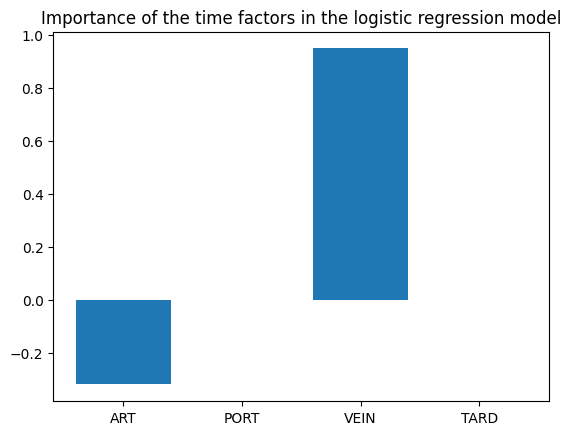

In [128]:
w_0, w_K, w_J, w_L = best_clf.get_weights()
plt.bar(np.arange(len(w_K)),w_K)
plt.title('Importance of the time factors in the logistic regression model')
plt.xticks(np.arange(len(w_K)),['ART','PORT','VEIN','TARD'])
plt.show()

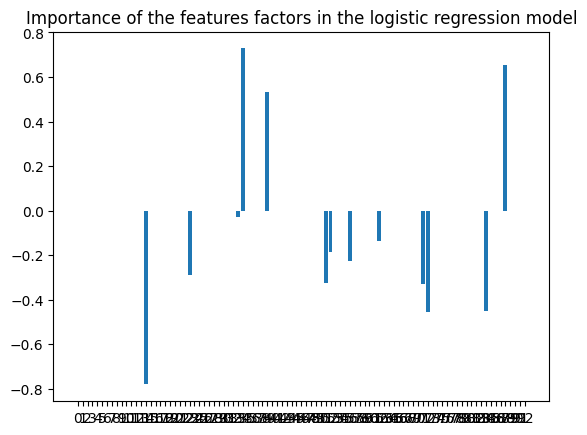

In [129]:
plt.bar(np.arange(len(w_J)), w_J)
plt.title("Importance of the features factors in the logistic regression model")
plt.xticks(np.arange(len(w_J)), [str(i) for i in range(len(w_J))])
plt.show()

In [130]:
print("Selected Features : ")
for i in range(len(w_J)):
    if w_J[i] != 0:
        print(dic_slice[i])

Selected Features : 
original_firstorder_Skewness
original_glcm_Correlation
original_glcm_InverseVariance
original_glcm_JointAverage
original_glcm_SumAverage
original_gldm_LargeDependenceLowGrayLevelEmphasis
original_gldm_LowGrayLevelEmphasis
original_glrlm_GrayLevelNonUniformity
original_glrlm_LongRunLowGrayLevelEmphasis
original_glrlm_ShortRunLowGrayLevelEmphasis
original_glszm_GrayLevelNonUniformity
original_glszm_LargeAreaLowGrayLevelEmphasis
original_glszm_SmallAreaLowGrayLevelEmphasis
original_ngtdm_Busyness


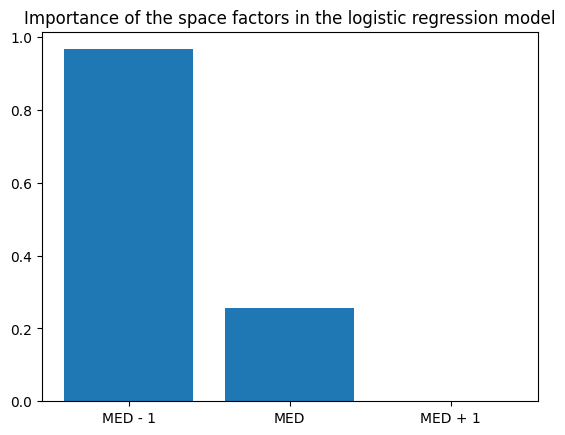

In [131]:
plt.bar(np.arange(len(w_L)), w_L)
plt.title("Importance of the space factors in the logistic regression model")
plt.xticks(np.arange(len(w_L)), ["MED - 1", "MED", "MED + 1"])
plt.show()

The final report has a summary of every results with more description and interpretations as we encourgae you to read it if you want to have an overall vision of the tensor analysis of the data.